In [1]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

import util.RAVDESS_dataset_util as Rd
import multimodal_vae
from train_mvae import build_model, train

from config_args import ConfigModelArgs, ConfigTrainArgs

In [3]:
cfg_model = ConfigModelArgs()
cfg_train = ConfigTrainArgs()

In [4]:
face_dataset = Rd.FaceEmotionDataset(
    root_dir=cfg_model.dataset_path,
    transform=transforms.Compose
    ([
        Rd.Rescale(cfg_model.img_size), 
        Rd.CenterCrop(cfg_model.img_size), 
        Rd.ToTensor()
    ]))

trainingset_len = len(face_dataset) // 100 * 95
testset_len = len(face_dataset) - trainingset_len
training_dataset, testing_dataset = torch.utils.data.random_split(
    face_dataset, 
    [trainingset_len, testset_len],
    #generator=torch.Generator().manual_seed(42)
)

dataset_loader = DataLoader(training_dataset, batch_size=cfg_train.batch_size,
                        shuffle=True, num_workers=cfg_train.num_workers)

testset_loader = DataLoader(testing_dataset, batch_size=cfg_train.batch_size,
                        shuffle=True, num_workers=cfg_train.num_workers)

print('training set size: ',trainingset_len,'\ntest set size: ',testset_len)

training set size:  6840 
test set size:  360


In [5]:
model: torch.nn.Module = build_model(
    cat_dim=cfg_model.cat_dim,
    latent_space_dim=cfg_model.z_dim,
    hidden_dim=cfg_model.hidden_dim,
    num_channels=cfg_model.channel_dim,
    loss_weights=cfg_model.loss_weights,
    expert_type=cfg_model.expert_type,
    use_cuda=True
).double()

In [6]:
training_losses = train(
    mvae_model=model,
    dataset_loader=dataset_loader,
    learning_rate=cfg_train.learning_rate,
    optim_betas=cfg_train.optim_betas,
    num_epochs=cfg_train.num_epochs,
    batch_size=cfg_train.batch_size,
    checkpoint_every=cfg_train.checkpoint_every,
    checkpoint_path=cfg_train.checkpoint_path,
    save_model=cfg_train.save_model,
    seed=cfg_train.seed,
    use_cuda=cfg_train.use_cuda,
    cfg=cfg_train
)

  1%|▏                         | 1/150 [01:06<2:45:42, 66.73s/it]

Multimodal losses:
Mean total loss: 4.388;
Mean reconstruction loss: 0.63145;
Mean kld_loss loss: 37.566;
Mean faces_reconstruction loss: 0.053916;
Mean emotions_reconstruction loss: 0.57753;

Face losses:
Mean total loss: 5.2777;
Mean reconstruction loss: 0.050567;
Mean kld_loss loss: 52.271;
Mean faces_reconstruction loss: 0.050567;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.8838;
Mean reconstruction loss: 0.40402;
Mean kld_loss loss: 14.798;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.40402;



  1%|▎                         | 2/150 [02:18<2:51:42, 69.61s/it]

Multimodal losses:
Mean total loss: 2.8855;
Mean reconstruction loss: 0.29423;
Mean kld_loss loss: 25.913;
Mean faces_reconstruction loss: 0.037832;
Mean emotions_reconstruction loss: 0.2564;

Face losses:
Mean total loss: 1.6296;
Mean reconstruction loss: 0.037688;
Mean kld_loss loss: 15.92;
Mean faces_reconstruction loss: 0.037688;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.1952;
Mean reconstruction loss: 0.15161;
Mean kld_loss loss: 10.436;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.15161;



  2%|▌                         | 3/150 [03:24<2:46:36, 68.00s/it]

Multimodal losses:
Mean total loss: 2.6142;
Mean reconstruction loss: 0.27659;
Mean kld_loss loss: 23.376;
Mean faces_reconstruction loss: 0.037178;
Mean emotions_reconstruction loss: 0.23941;

Face losses:
Mean total loss: 1.2241;
Mean reconstruction loss: 0.037062;
Mean kld_loss loss: 11.871;
Mean faces_reconstruction loss: 0.037062;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.12;
Mean reconstruction loss: 0.137;
Mean kld_loss loss: 9.8299;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.137;



  3%|▋                         | 4/150 [04:30<2:43:12, 67.07s/it]

Multimodal losses:
Mean total loss: 2.6234;
Mean reconstruction loss: 0.28909;
Mean kld_loss loss: 23.343;
Mean faces_reconstruction loss: 0.037005;
Mean emotions_reconstruction loss: 0.25208;

Face losses:
Mean total loss: 1.1123;
Mean reconstruction loss: 0.036913;
Mean kld_loss loss: 10.754;
Mean faces_reconstruction loss: 0.036913;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.1087;
Mean reconstruction loss: 0.12055;
Mean kld_loss loss: 9.8812;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.12055;



  3%|▊                         | 5/150 [05:39<2:43:52, 67.81s/it]

Multimodal losses:
Mean total loss: 2.5374;
Mean reconstruction loss: 0.28092;
Mean kld_loss loss: 22.565;
Mean faces_reconstruction loss: 0.036726;
Mean emotions_reconstruction loss: 0.2442;

Face losses:
Mean total loss: 1.0173;
Mean reconstruction loss: 0.036666;
Mean kld_loss loss: 9.8061;
Mean faces_reconstruction loss: 0.036666;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.1085;
Mean reconstruction loss: 0.13057;
Mean kld_loss loss: 9.7788;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.13057;



  4%|█                         | 6/150 [06:48<2:43:42, 68.21s/it]

Multimodal losses:
Mean total loss: 2.4846;
Mean reconstruction loss: 0.28956;
Mean kld_loss loss: 21.951;
Mean faces_reconstruction loss: 0.036598;
Mean emotions_reconstruction loss: 0.25296;

Face losses:
Mean total loss: 0.93786;
Mean reconstruction loss: 0.036555;
Mean kld_loss loss: 9.013;
Mean faces_reconstruction loss: 0.036555;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0938;
Mean reconstruction loss: 0.12938;
Mean kld_loss loss: 9.6444;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.12938;



  5%|█▏                        | 7/150 [08:01<2:46:36, 69.90s/it]

Multimodal losses:
Mean total loss: 2.4767;
Mean reconstruction loss: 0.28156;
Mean kld_loss loss: 21.952;
Mean faces_reconstruction loss: 0.036543;
Mean emotions_reconstruction loss: 0.24502;

Face losses:
Mean total loss: 0.89896;
Mean reconstruction loss: 0.036517;
Mean kld_loss loss: 8.6244;
Mean faces_reconstruction loss: 0.036517;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0857;
Mean reconstruction loss: 0.12256;
Mean kld_loss loss: 9.6315;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.12256;



  5%|█▍                        | 8/150 [09:10<2:44:32, 69.53s/it]

Multimodal losses:
Mean total loss: 2.4212;
Mean reconstruction loss: 0.28708;
Mean kld_loss loss: 21.341;
Mean faces_reconstruction loss: 0.036528;
Mean emotions_reconstruction loss: 0.25055;

Face losses:
Mean total loss: 0.84672;
Mean reconstruction loss: 0.036514;
Mean kld_loss loss: 8.102;
Mean faces_reconstruction loss: 0.036514;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0833;
Mean reconstruction loss: 0.1216;
Mean kld_loss loss: 9.6171;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.1216;



  6%|█▌                        | 9/150 [10:18<2:42:35, 69.19s/it]

Multimodal losses:
Mean total loss: 2.3832;
Mean reconstruction loss: 0.28561;
Mean kld_loss loss: 20.976;
Mean faces_reconstruction loss: 0.036466;
Mean emotions_reconstruction loss: 0.24915;

Face losses:
Mean total loss: 0.77637;
Mean reconstruction loss: 0.036465;
Mean kld_loss loss: 7.399;
Mean faces_reconstruction loss: 0.036465;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0687;
Mean reconstruction loss: 0.12653;
Mean kld_loss loss: 9.4215;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.12653;



  7%|█▋                       | 10/150 [11:27<2:41:16, 69.12s/it]

Multimodal losses:
Mean total loss: 2.3759;
Mean reconstruction loss: 0.28851;
Mean kld_loss loss: 20.874;
Mean faces_reconstruction loss: 0.036403;
Mean emotions_reconstruction loss: 0.2521;

Face losses:
Mean total loss: 0.72478;
Mean reconstruction loss: 0.036414;
Mean kld_loss loss: 6.8836;
Mean faces_reconstruction loss: 0.036414;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0657;
Mean reconstruction loss: 0.11771;
Mean kld_loss loss: 9.4802;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.11771;



  7%|█▊                       | 11/150 [12:37<2:40:14, 69.17s/it]

Multimodal losses:
Mean total loss: 2.3459;
Mean reconstruction loss: 0.28816;
Mean kld_loss loss: 20.578;
Mean faces_reconstruction loss: 0.036288;
Mean emotions_reconstruction loss: 0.25187;

Face losses:
Mean total loss: 0.68719;
Mean reconstruction loss: 0.036318;
Mean kld_loss loss: 6.5087;
Mean faces_reconstruction loss: 0.036318;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0558;
Mean reconstruction loss: 0.11921;
Mean kld_loss loss: 9.3657;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.11921;



  8%|██                       | 12/150 [13:48<2:40:46, 69.90s/it]

Multimodal losses:
Mean total loss: 2.3143;
Mean reconstruction loss: 0.28355;
Mean kld_loss loss: 20.307;
Mean faces_reconstruction loss: 0.03633;
Mean emotions_reconstruction loss: 0.24722;

Face losses:
Mean total loss: 0.64436;
Mean reconstruction loss: 0.036368;
Mean kld_loss loss: 6.08;
Mean faces_reconstruction loss: 0.036368;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0574;
Mean reconstruction loss: 0.12671;
Mean kld_loss loss: 9.3071;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.12671;



  9%|██▏                      | 13/150 [14:54<2:36:36, 68.59s/it]

Multimodal losses:
Mean total loss: 2.2773;
Mean reconstruction loss: 0.27525;
Mean kld_loss loss: 20.021;
Mean faces_reconstruction loss: 0.036206;
Mean emotions_reconstruction loss: 0.23904;

Face losses:
Mean total loss: 0.60538;
Mean reconstruction loss: 0.036277;
Mean kld_loss loss: 5.691;
Mean faces_reconstruction loss: 0.036277;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0324;
Mean reconstruction loss: 0.11406;
Mean kld_loss loss: 9.1832;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.11406;



  9%|██▎                      | 14/150 [16:01<2:34:50, 68.31s/it]

Multimodal losses:
Mean total loss: 2.2728;
Mean reconstruction loss: 0.28488;
Mean kld_loss loss: 19.879;
Mean faces_reconstruction loss: 0.036232;
Mean emotions_reconstruction loss: 0.24864;

Face losses:
Mean total loss: 0.59265;
Mean reconstruction loss: 0.036302;
Mean kld_loss loss: 5.5635;
Mean faces_reconstruction loss: 0.036302;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0461;
Mean reconstruction loss: 0.12166;
Mean kld_loss loss: 9.2444;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.12166;



 10%|██▌                      | 15/150 [17:06<2:31:29, 67.33s/it]

Multimodal losses:
Mean total loss: 2.2368;
Mean reconstruction loss: 0.28481;
Mean kld_loss loss: 19.52;
Mean faces_reconstruction loss: 0.036223;
Mean emotions_reconstruction loss: 0.24858;

Face losses:
Mean total loss: 0.55196;
Mean reconstruction loss: 0.036298;
Mean kld_loss loss: 5.1566;
Mean faces_reconstruction loss: 0.036298;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.031;
Mean reconstruction loss: 0.11971;
Mean kld_loss loss: 9.1127;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.11971;



 11%|██▋                      | 16/150 [18:17<2:32:38, 68.35s/it]

Multimodal losses:
Mean total loss: 2.222;
Mean reconstruction loss: 0.27744;
Mean kld_loss loss: 19.446;
Mean faces_reconstruction loss: 0.036182;
Mean emotions_reconstruction loss: 0.24126;

Face losses:
Mean total loss: 0.52619;
Mean reconstruction loss: 0.036262;
Mean kld_loss loss: 4.8993;
Mean faces_reconstruction loss: 0.036262;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0425;
Mean reconstruction loss: 0.11854;
Mean kld_loss loss: 9.2397;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.11854;



 11%|██▊                      | 17/150 [19:28<2:33:01, 69.04s/it]

Multimodal losses:
Mean total loss: 2.223;
Mean reconstruction loss: 0.29395;
Mean kld_loss loss: 19.29;
Mean faces_reconstruction loss: 0.036173;
Mean emotions_reconstruction loss: 0.25778;

Face losses:
Mean total loss: 0.50146;
Mean reconstruction loss: 0.036245;
Mean kld_loss loss: 4.6522;
Mean faces_reconstruction loss: 0.036245;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0329;
Mean reconstruction loss: 0.11387;
Mean kld_loss loss: 9.1905;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.11387;



 12%|███                      | 18/150 [20:36<2:31:12, 68.73s/it]

Multimodal losses:
Mean total loss: 2.214;
Mean reconstruction loss: 0.28909;
Mean kld_loss loss: 19.249;
Mean faces_reconstruction loss: 0.036113;
Mean emotions_reconstruction loss: 0.25298;

Face losses:
Mean total loss: 0.47978;
Mean reconstruction loss: 0.036215;
Mean kld_loss loss: 4.4356;
Mean faces_reconstruction loss: 0.036215;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0334;
Mean reconstruction loss: 0.11653;
Mean kld_loss loss: 9.1686;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.11653;



 13%|███▏                     | 19/150 [21:44<2:29:28, 68.46s/it]

Multimodal losses:
Mean total loss: 2.2462;
Mean reconstruction loss: 0.29311;
Mean kld_loss loss: 19.531;
Mean faces_reconstruction loss: 0.036098;
Mean emotions_reconstruction loss: 0.25701;

Face losses:
Mean total loss: 0.5993;
Mean reconstruction loss: 0.036202;
Mean kld_loss loss: 5.631;
Mean faces_reconstruction loss: 0.036202;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0401;
Mean reconstruction loss: 0.1155;
Mean kld_loss loss: 9.2461;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.1155;



 13%|███▎                     | 20/150 [22:51<2:27:42, 68.17s/it]

Multimodal losses:
Mean total loss: 2.2078;
Mean reconstruction loss: 0.29408;
Mean kld_loss loss: 19.138;
Mean faces_reconstruction loss: 0.036093;
Mean emotions_reconstruction loss: 0.25799;

Face losses:
Mean total loss: 0.43846;
Mean reconstruction loss: 0.036186;
Mean kld_loss loss: 4.0227;
Mean faces_reconstruction loss: 0.036186;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0302;
Mean reconstruction loss: 0.11818;
Mean kld_loss loss: 9.1199;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.11818;



 14%|███▌                     | 21/150 [24:00<2:27:02, 68.39s/it]

Multimodal losses:
Mean total loss: 2.1652;
Mean reconstruction loss: 0.28924;
Mean kld_loss loss: 18.759;
Mean faces_reconstruction loss: 0.036058;
Mean emotions_reconstruction loss: 0.25318;

Face losses:
Mean total loss: 0.41828;
Mean reconstruction loss: 0.036174;
Mean kld_loss loss: 3.8211;
Mean faces_reconstruction loss: 0.036174;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0074;
Mean reconstruction loss: 0.10564;
Mean kld_loss loss: 9.0178;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.10564;



 15%|███▋                     | 22/150 [25:09<2:26:31, 68.69s/it]

Multimodal losses:
Mean total loss: 2.1453;
Mean reconstruction loss: 0.27995;
Mean kld_loss loss: 18.653;
Mean faces_reconstruction loss: 0.03602;
Mean emotions_reconstruction loss: 0.24393;

Face losses:
Mean total loss: 0.40827;
Mean reconstruction loss: 0.036127;
Mean kld_loss loss: 3.7214;
Mean faces_reconstruction loss: 0.036127;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0254;
Mean reconstruction loss: 0.12052;
Mean kld_loss loss: 9.0489;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.12052;



 15%|███▊                     | 23/150 [26:17<2:24:31, 68.28s/it]

Multimodal losses:
Mean total loss: 2.1508;
Mean reconstruction loss: 0.28667;
Mean kld_loss loss: 18.641;
Mean faces_reconstruction loss: 0.036015;
Mean emotions_reconstruction loss: 0.25066;

Face losses:
Mean total loss: 0.39173;
Mean reconstruction loss: 0.036132;
Mean kld_loss loss: 3.556;
Mean faces_reconstruction loss: 0.036132;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.022;
Mean reconstruction loss: 0.11444;
Mean kld_loss loss: 9.0751;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.11444;



 16%|████                     | 24/150 [27:26<2:23:53, 68.52s/it]

Multimodal losses:
Mean total loss: 2.1365;
Mean reconstruction loss: 0.28609;
Mean kld_loss loss: 18.504;
Mean faces_reconstruction loss: 0.036034;
Mean emotions_reconstruction loss: 0.25006;

Face losses:
Mean total loss: 0.37489;
Mean reconstruction loss: 0.036154;
Mean kld_loss loss: 3.3873;
Mean faces_reconstruction loss: 0.036154;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0158;
Mean reconstruction loss: 0.11249;
Mean kld_loss loss: 9.0332;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.11249;



 17%|████▏                    | 25/150 [28:36<2:23:36, 68.94s/it]

Multimodal losses:
Mean total loss: 2.1376;
Mean reconstruction loss: 0.29874;
Mean kld_loss loss: 18.389;
Mean faces_reconstruction loss: 0.035994;
Mean emotions_reconstruction loss: 0.26275;

Face losses:
Mean total loss: 0.36245;
Mean reconstruction loss: 0.036129;
Mean kld_loss loss: 3.2632;
Mean faces_reconstruction loss: 0.036129;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0002;
Mean reconstruction loss: 0.0978;
Mean kld_loss loss: 9.024;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.0978;



 17%|████▎                    | 26/150 [29:46<2:23:15, 69.32s/it]

Multimodal losses:
Mean total loss: 2.1266;
Mean reconstruction loss: 0.27588;
Mean kld_loss loss: 18.507;
Mean faces_reconstruction loss: 0.036016;
Mean emotions_reconstruction loss: 0.23987;

Face losses:
Mean total loss: 0.37117;
Mean reconstruction loss: 0.036131;
Mean kld_loss loss: 3.3504;
Mean faces_reconstruction loss: 0.036131;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0215;
Mean reconstruction loss: 0.12168;
Mean kld_loss loss: 8.9981;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.12168;



 18%|████▌                    | 27/150 [30:53<2:20:34, 68.58s/it]

Multimodal losses:
Mean total loss: 2.1086;
Mean reconstruction loss: 0.29732;
Mean kld_loss loss: 18.113;
Mean faces_reconstruction loss: 0.035997;
Mean emotions_reconstruction loss: 0.26133;

Face losses:
Mean total loss: 0.34652;
Mean reconstruction loss: 0.036123;
Mean kld_loss loss: 3.104;
Mean faces_reconstruction loss: 0.036123;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0035;
Mean reconstruction loss: 0.10461;
Mean kld_loss loss: 8.9889;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.10461;



 19%|████▋                    | 28/150 [31:59<2:17:47, 67.76s/it]

Multimodal losses:
Mean total loss: 2.1;
Mean reconstruction loss: 0.29141;
Mean kld_loss loss: 18.086;
Mean faces_reconstruction loss: 0.035992;
Mean emotions_reconstruction loss: 0.25541;

Face losses:
Mean total loss: 0.33988;
Mean reconstruction loss: 0.03612;
Mean kld_loss loss: 3.0376;
Mean faces_reconstruction loss: 0.03612;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0091;
Mean reconstruction loss: 0.11115;
Mean kld_loss loss: 8.9797;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.11115;



 19%|████▊                    | 29/150 [33:05<2:15:39, 67.27s/it]

Multimodal losses:
Mean total loss: 2.0881;
Mean reconstruction loss: 0.29201;
Mean kld_loss loss: 17.961;
Mean faces_reconstruction loss: 0.035991;
Mean emotions_reconstruction loss: 0.25602;

Face losses:
Mean total loss: 0.34707;
Mean reconstruction loss: 0.03612;
Mean kld_loss loss: 3.1095;
Mean faces_reconstruction loss: 0.03612;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0076;
Mean reconstruction loss: 0.11533;
Mean kld_loss loss: 8.923;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.11533;



 20%|█████                    | 30/150 [34:14<2:15:43, 67.86s/it]

Multimodal losses:
Mean total loss: 2.0873;
Mean reconstruction loss: 0.29681;
Mean kld_loss loss: 17.905;
Mean faces_reconstruction loss: 0.036033;
Mean emotions_reconstruction loss: 0.26078;

Face losses:
Mean total loss: 0.3305;
Mean reconstruction loss: 0.036153;
Mean kld_loss loss: 2.9435;
Mean faces_reconstruction loss: 0.036153;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0019;
Mean reconstruction loss: 0.10972;
Mean kld_loss loss: 8.9214;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.10972;



 21%|█████▏                   | 31/150 [35:20<2:13:41, 67.41s/it]

Multimodal losses:
Mean total loss: 2.0881;
Mean reconstruction loss: 0.30062;
Mean kld_loss loss: 17.875;
Mean faces_reconstruction loss: 0.035962;
Mean emotions_reconstruction loss: 0.26466;

Face losses:
Mean total loss: 0.32265;
Mean reconstruction loss: 0.036105;
Mean kld_loss loss: 2.8655;
Mean faces_reconstruction loss: 0.036105;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.99833;
Mean reconstruction loss: 0.10868;
Mean kld_loss loss: 8.8965;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.10868;



 21%|█████▎                   | 32/150 [36:27<2:12:21, 67.30s/it]

Multimodal losses:
Mean total loss: 2.0868;
Mean reconstruction loss: 0.29228;
Mean kld_loss loss: 17.945;
Mean faces_reconstruction loss: 0.035979;
Mean emotions_reconstruction loss: 0.2563;

Face losses:
Mean total loss: 0.32468;
Mean reconstruction loss: 0.036124;
Mean kld_loss loss: 2.8856;
Mean faces_reconstruction loss: 0.036124;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.99751;
Mean reconstruction loss: 0.10394;
Mean kld_loss loss: 8.9357;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.10394;



 22%|█████▌                   | 33/150 [37:37<2:12:50, 68.12s/it]

Multimodal losses:
Mean total loss: 2.0584;
Mean reconstruction loss: 0.2847;
Mean kld_loss loss: 17.737;
Mean faces_reconstruction loss: 0.036001;
Mean emotions_reconstruction loss: 0.2487;

Face losses:
Mean total loss: 0.31552;
Mean reconstruction loss: 0.036137;
Mean kld_loss loss: 2.7938;
Mean faces_reconstruction loss: 0.036137;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.99446;
Mean reconstruction loss: 0.10621;
Mean kld_loss loss: 8.8825;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.10621;



 23%|█████▋                   | 34/150 [38:45<2:11:38, 68.09s/it]

Multimodal losses:
Mean total loss: 2.0529;
Mean reconstruction loss: 0.29046;
Mean kld_loss loss: 17.625;
Mean faces_reconstruction loss: 0.035966;
Mean emotions_reconstruction loss: 0.25449;

Face losses:
Mean total loss: 0.3119;
Mean reconstruction loss: 0.03611;
Mean kld_loss loss: 2.7579;
Mean faces_reconstruction loss: 0.03611;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.98278;
Mean reconstruction loss: 0.10014;
Mean kld_loss loss: 8.8264;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.10014;



 23%|█████▊                   | 35/150 [39:54<2:10:51, 68.27s/it]

Multimodal losses:
Mean total loss: 2.0471;
Mean reconstruction loss: 0.29508;
Mean kld_loss loss: 17.52;
Mean faces_reconstruction loss: 0.03592;
Mean emotions_reconstruction loss: 0.25916;

Face losses:
Mean total loss: 0.31271;
Mean reconstruction loss: 0.036084;
Mean kld_loss loss: 2.7663;
Mean faces_reconstruction loss: 0.036084;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.99473;
Mean reconstruction loss: 0.11651;
Mean kld_loss loss: 8.7822;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.11651;



 24%|██████                   | 36/150 [41:03<2:09:50, 68.34s/it]

Multimodal losses:
Mean total loss: 2.024;
Mean reconstruction loss: 0.27527;
Mean kld_loss loss: 17.487;
Mean faces_reconstruction loss: 0.03594;
Mean emotions_reconstruction loss: 0.23933;

Face losses:
Mean total loss: 0.3111;
Mean reconstruction loss: 0.036094;
Mean kld_loss loss: 2.7501;
Mean faces_reconstruction loss: 0.036094;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0018;
Mean reconstruction loss: 0.12062;
Mean kld_loss loss: 8.8116;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.12062;



 25%|██████▏                  | 37/150 [42:17<2:12:07, 70.16s/it]

Multimodal losses:
Mean total loss: 2.0388;
Mean reconstruction loss: 0.28333;
Mean kld_loss loss: 17.555;
Mean faces_reconstruction loss: 0.03591;
Mean emotions_reconstruction loss: 0.24741;

Face losses:
Mean total loss: 0.30768;
Mean reconstruction loss: 0.036071;
Mean kld_loss loss: 2.7161;
Mean faces_reconstruction loss: 0.036071;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0049;
Mean reconstruction loss: 0.1134;
Mean kld_loss loss: 8.9152;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.1134;



 25%|██████▎                  | 38/150 [43:26<2:10:31, 69.92s/it]

Multimodal losses:
Mean total loss: 2.0606;
Mean reconstruction loss: 0.29754;
Mean kld_loss loss: 17.631;
Mean faces_reconstruction loss: 0.035915;
Mean emotions_reconstruction loss: 0.26163;

Face losses:
Mean total loss: 0.30491;
Mean reconstruction loss: 0.036094;
Mean kld_loss loss: 2.6881;
Mean faces_reconstruction loss: 0.036094;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0098;
Mean reconstruction loss: 0.12073;
Mean kld_loss loss: 8.8909;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.12073;



 26%|██████▌                  | 39/150 [44:33<2:07:44, 69.05s/it]

Multimodal losses:
Mean total loss: 2.0467;
Mean reconstruction loss: 0.29662;
Mean kld_loss loss: 17.501;
Mean faces_reconstruction loss: 0.035928;
Mean emotions_reconstruction loss: 0.26069;

Face losses:
Mean total loss: 0.30039;
Mean reconstruction loss: 0.036085;
Mean kld_loss loss: 2.6431;
Mean faces_reconstruction loss: 0.036085;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0011;
Mean reconstruction loss: 0.11575;
Mean kld_loss loss: 8.8531;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.11575;



 27%|██████▋                  | 40/150 [45:40<2:05:21, 68.38s/it]

Multimodal losses:
Mean total loss: 2.0571;
Mean reconstruction loss: 0.30713;
Mean kld_loss loss: 17.5;
Mean faces_reconstruction loss: 0.03592;
Mean emotions_reconstruction loss: 0.27121;

Face losses:
Mean total loss: 0.3151;
Mean reconstruction loss: 0.036086;
Mean kld_loss loss: 2.7901;
Mean faces_reconstruction loss: 0.036086;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.9967;
Mean reconstruction loss: 0.11352;
Mean kld_loss loss: 8.8317;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.11352;



 27%|██████▊                  | 41/150 [46:47<2:03:11, 67.81s/it]

Multimodal losses:
Mean total loss: 2.0261;
Mean reconstruction loss: 0.28218;
Mean kld_loss loss: 17.439;
Mean faces_reconstruction loss: 0.035898;
Mean emotions_reconstruction loss: 0.24628;

Face losses:
Mean total loss: 0.30095;
Mean reconstruction loss: 0.036063;
Mean kld_loss loss: 2.6488;
Mean faces_reconstruction loss: 0.036063;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.99037;
Mean reconstruction loss: 0.1102;
Mean kld_loss loss: 8.8017;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.1102;



 28%|███████                  | 42/150 [47:59<2:04:25, 69.13s/it]

Multimodal losses:
Mean total loss: 2.0312;
Mean reconstruction loss: 0.29083;
Mean kld_loss loss: 17.404;
Mean faces_reconstruction loss: 0.035891;
Mean emotions_reconstruction loss: 0.25494;

Face losses:
Mean total loss: 0.29786;
Mean reconstruction loss: 0.036066;
Mean kld_loss loss: 2.618;
Mean faces_reconstruction loss: 0.036066;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.98977;
Mean reconstruction loss: 0.10695;
Mean kld_loss loss: 8.8282;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.10695;



 29%|███████▏                 | 43/150 [49:08<2:03:12, 69.09s/it]

Multimodal losses:
Mean total loss: 2.0193;
Mean reconstruction loss: 0.28822;
Mean kld_loss loss: 17.311;
Mean faces_reconstruction loss: 0.035897;
Mean emotions_reconstruction loss: 0.25232;

Face losses:
Mean total loss: 0.30122;
Mean reconstruction loss: 0.036071;
Mean kld_loss loss: 2.6515;
Mean faces_reconstruction loss: 0.036071;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.99457;
Mean reconstruction loss: 0.11458;
Mean kld_loss loss: 8.7999;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.11458;



 29%|███████▎                 | 44/150 [50:18<2:02:48, 69.51s/it]

Multimodal losses:
Mean total loss: 2.0017;
Mean reconstruction loss: 0.27834;
Mean kld_loss loss: 17.233;
Mean faces_reconstruction loss: 0.035894;
Mean emotions_reconstruction loss: 0.24244;

Face losses:
Mean total loss: 0.30502;
Mean reconstruction loss: 0.036066;
Mean kld_loss loss: 2.6895;
Mean faces_reconstruction loss: 0.036066;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0002;
Mean reconstruction loss: 0.11983;
Mean kld_loss loss: 8.8041;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.11983;



 30%|███████▌                 | 45/150 [51:26<2:00:40, 68.96s/it]

Multimodal losses:
Mean total loss: 2.0345;
Mean reconstruction loss: 0.2952;
Mean kld_loss loss: 17.393;
Mean faces_reconstruction loss: 0.035878;
Mean emotions_reconstruction loss: 0.25932;

Face losses:
Mean total loss: 0.31028;
Mean reconstruction loss: 0.036047;
Mean kld_loss loss: 2.7424;
Mean faces_reconstruction loss: 0.036047;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.012;
Mean reconstruction loss: 0.12522;
Mean kld_loss loss: 8.8675;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.12522;



 31%|███████▋                 | 46/150 [52:34<1:59:08, 68.73s/it]

Multimodal losses:
Mean total loss: 2.0283;
Mean reconstruction loss: 0.29866;
Mean kld_loss loss: 17.296;
Mean faces_reconstruction loss: 0.035906;
Mean emotions_reconstruction loss: 0.26275;

Face losses:
Mean total loss: 0.29622;
Mean reconstruction loss: 0.036079;
Mean kld_loss loss: 2.6014;
Mean faces_reconstruction loss: 0.036079;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.98464;
Mean reconstruction loss: 0.10533;
Mean kld_loss loss: 8.7931;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.10533;



 31%|███████▊                 | 47/150 [53:47<1:59:58, 69.88s/it]

Multimodal losses:
Mean total loss: 2.0075;
Mean reconstruction loss: 0.29192;
Mean kld_loss loss: 17.156;
Mean faces_reconstruction loss: 0.035886;
Mean emotions_reconstruction loss: 0.25603;

Face losses:
Mean total loss: 0.30273;
Mean reconstruction loss: 0.036059;
Mean kld_loss loss: 2.6667;
Mean faces_reconstruction loss: 0.036059;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.98649;
Mean reconstruction loss: 0.1085;
Mean kld_loss loss: 8.7799;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.1085;



 32%|████████                 | 48/150 [54:56<1:58:21, 69.62s/it]

Multimodal losses:
Mean total loss: 2.0287;
Mean reconstruction loss: 0.30616;
Mean kld_loss loss: 17.226;
Mean faces_reconstruction loss: 0.035857;
Mean emotions_reconstruction loss: 0.2703;

Face losses:
Mean total loss: 0.29764;
Mean reconstruction loss: 0.036045;
Mean kld_loss loss: 2.6159;
Mean faces_reconstruction loss: 0.036045;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.98681;
Mean reconstruction loss: 0.11117;
Mean kld_loss loss: 8.7564;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.11117;



 33%|████████▏                | 49/150 [56:07<1:58:10, 70.21s/it]

Multimodal losses:
Mean total loss: 1.9922;
Mean reconstruction loss: 0.276;
Mean kld_loss loss: 17.162;
Mean faces_reconstruction loss: 0.035876;
Mean emotions_reconstruction loss: 0.24012;

Face losses:
Mean total loss: 0.30252;
Mean reconstruction loss: 0.036063;
Mean kld_loss loss: 2.6646;
Mean faces_reconstruction loss: 0.036063;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.99015;
Mean reconstruction loss: 0.11687;
Mean kld_loss loss: 8.7328;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.11687;



 33%|████████▎                | 50/150 [57:14<1:55:26, 69.26s/it]

Multimodal losses:
Mean total loss: 2.0127;
Mean reconstruction loss: 0.28026;
Mean kld_loss loss: 17.324;
Mean faces_reconstruction loss: 0.035857;
Mean emotions_reconstruction loss: 0.2444;

Face losses:
Mean total loss: 0.2981;
Mean reconstruction loss: 0.036049;
Mean kld_loss loss: 2.6205;
Mean faces_reconstruction loss: 0.036049;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.99296;
Mean reconstruction loss: 0.11287;
Mean kld_loss loss: 8.8009;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.11287;



 34%|████████▌                | 51/150 [58:25<1:54:49, 69.59s/it]

Multimodal losses:
Mean total loss: 2.0166;
Mean reconstruction loss: 0.29321;
Mean kld_loss loss: 17.233;
Mean faces_reconstruction loss: 0.035837;
Mean emotions_reconstruction loss: 0.25737;

Face losses:
Mean total loss: 0.30445;
Mean reconstruction loss: 0.036031;
Mean kld_loss loss: 2.6842;
Mean faces_reconstruction loss: 0.036031;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.97918;
Mean reconstruction loss: 0.097329;
Mean kld_loss loss: 8.8185;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.097329;



 35%|████████▋                | 52/150 [59:31<1:51:48, 68.46s/it]

Multimodal losses:
Mean total loss: 2.0244;
Mean reconstruction loss: 0.29493;
Mean kld_loss loss: 17.295;
Mean faces_reconstruction loss: 0.035873;
Mean emotions_reconstruction loss: 0.25906;

Face losses:
Mean total loss: 0.29126;
Mean reconstruction loss: 0.036073;
Mean kld_loss loss: 2.5519;
Mean faces_reconstruction loss: 0.036073;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.99507;
Mean reconstruction loss: 0.10756;
Mean kld_loss loss: 8.8751;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.10756;



 35%|████████▏              | 53/150 [1:00:41<1:51:44, 69.12s/it]

Multimodal losses:
Mean total loss: 2.0045;
Mean reconstruction loss: 0.28904;
Mean kld_loss loss: 17.155;
Mean faces_reconstruction loss: 0.035855;
Mean emotions_reconstruction loss: 0.25318;

Face losses:
Mean total loss: 0.29838;
Mean reconstruction loss: 0.036071;
Mean kld_loss loss: 2.6231;
Mean faces_reconstruction loss: 0.036071;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.99087;
Mean reconstruction loss: 0.11185;
Mean kld_loss loss: 8.7903;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.11185;



 36%|████████▎              | 54/150 [1:01:54<1:52:13, 70.14s/it]

Multimodal losses:
Mean total loss: 2.006;
Mean reconstruction loss: 0.28961;
Mean kld_loss loss: 17.164;
Mean faces_reconstruction loss: 0.035861;
Mean emotions_reconstruction loss: 0.25375;

Face losses:
Mean total loss: 0.30343;
Mean reconstruction loss: 0.036051;
Mean kld_loss loss: 2.6738;
Mean faces_reconstruction loss: 0.036051;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.98392;
Mean reconstruction loss: 0.1048;
Mean kld_loss loss: 8.7912;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.1048;



 37%|████████▍              | 55/150 [1:03:04<1:51:09, 70.21s/it]

Multimodal losses:
Mean total loss: 2.0101;
Mean reconstruction loss: 0.28867;
Mean kld_loss loss: 17.214;
Mean faces_reconstruction loss: 0.035823;
Mean emotions_reconstruction loss: 0.25284;

Face losses:
Mean total loss: 0.29915;
Mean reconstruction loss: 0.036025;
Mean kld_loss loss: 2.6313;
Mean faces_reconstruction loss: 0.036025;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0039;
Mean reconstruction loss: 0.1218;
Mean kld_loss loss: 8.8212;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.1218;



 37%|████████▌              | 56/150 [1:04:14<1:49:50, 70.11s/it]

Multimodal losses:
Mean total loss: 2.0073;
Mean reconstruction loss: 0.28832;
Mean kld_loss loss: 17.189;
Mean faces_reconstruction loss: 0.035883;
Mean emotions_reconstruction loss: 0.25244;

Face losses:
Mean total loss: 0.29153;
Mean reconstruction loss: 0.036094;
Mean kld_loss loss: 2.5543;
Mean faces_reconstruction loss: 0.036094;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.99054;
Mean reconstruction loss: 0.10854;
Mean kld_loss loss: 8.82;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.10854;



 38%|████████▋              | 57/150 [1:05:22<1:47:53, 69.61s/it]

Multimodal losses:
Mean total loss: 1.9902;
Mean reconstruction loss: 0.28356;
Mean kld_loss loss: 17.066;
Mean faces_reconstruction loss: 0.035837;
Mean emotions_reconstruction loss: 0.24773;

Face losses:
Mean total loss: 0.30587;
Mean reconstruction loss: 0.03604;
Mean kld_loss loss: 2.6984;
Mean faces_reconstruction loss: 0.03604;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0089;
Mean reconstruction loss: 0.12677;
Mean kld_loss loss: 8.8212;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.12677;



 39%|████████▉              | 58/150 [1:06:32<1:46:32, 69.48s/it]

Multimodal losses:
Mean total loss: 1.9969;
Mean reconstruction loss: 0.28686;
Mean kld_loss loss: 17.101;
Mean faces_reconstruction loss: 0.03583;
Mean emotions_reconstruction loss: 0.25103;

Face losses:
Mean total loss: 0.28953;
Mean reconstruction loss: 0.03604;
Mean kld_loss loss: 2.5349;
Mean faces_reconstruction loss: 0.03604;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.97928;
Mean reconstruction loss: 0.10734;
Mean kld_loss loss: 8.7194;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.10734;



 39%|█████████              | 59/150 [1:07:38<1:44:09, 68.68s/it]

Multimodal losses:
Mean total loss: 1.9969;
Mean reconstruction loss: 0.29804;
Mean kld_loss loss: 16.989;
Mean faces_reconstruction loss: 0.03585;
Mean emotions_reconstruction loss: 0.26219;

Face losses:
Mean total loss: 0.30479;
Mean reconstruction loss: 0.03606;
Mean kld_loss loss: 2.6873;
Mean faces_reconstruction loss: 0.03606;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.97851;
Mean reconstruction loss: 0.10199;
Mean kld_loss loss: 8.7651;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.10199;



 40%|█████████▏             | 60/150 [1:08:46<1:42:37, 68.42s/it]

Multimodal losses:
Mean total loss: 1.9803;
Mean reconstruction loss: 0.29037;
Mean kld_loss loss: 16.9;
Mean faces_reconstruction loss: 0.03585;
Mean emotions_reconstruction loss: 0.25452;

Face losses:
Mean total loss: 0.31291;
Mean reconstruction loss: 0.036053;
Mean kld_loss loss: 2.7685;
Mean faces_reconstruction loss: 0.036053;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.97264;
Mean reconstruction loss: 0.10012;
Mean kld_loss loss: 8.7252;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.10012;



 41%|█████████▎             | 61/150 [1:09:53<1:40:54, 68.03s/it]

Multimodal losses:
Mean total loss: 1.9881;
Mean reconstruction loss: 0.29598;
Mean kld_loss loss: 16.921;
Mean faces_reconstruction loss: 0.03582;
Mean emotions_reconstruction loss: 0.26016;

Face losses:
Mean total loss: 0.31398;
Mean reconstruction loss: 0.036036;
Mean kld_loss loss: 2.7794;
Mean faces_reconstruction loss: 0.036036;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.98146;
Mean reconstruction loss: 0.10459;
Mean kld_loss loss: 8.7688;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.10459;



 41%|█████████▌             | 62/150 [1:11:02<1:39:58, 68.16s/it]

Multimodal losses:
Mean total loss: 1.9952;
Mean reconstruction loss: 0.29781;
Mean kld_loss loss: 16.974;
Mean faces_reconstruction loss: 0.035804;
Mean emotions_reconstruction loss: 0.262;

Face losses:
Mean total loss: 0.31364;
Mean reconstruction loss: 0.036018;
Mean kld_loss loss: 2.7762;
Mean faces_reconstruction loss: 0.036018;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.99359;
Mean reconstruction loss: 0.11435;
Mean kld_loss loss: 8.7924;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.11435;



 42%|█████████▋             | 63/150 [1:12:10<1:38:41, 68.06s/it]

Multimodal losses:
Mean total loss: 1.9853;
Mean reconstruction loss: 0.29242;
Mean kld_loss loss: 16.929;
Mean faces_reconstruction loss: 0.035825;
Mean emotions_reconstruction loss: 0.2566;

Face losses:
Mean total loss: 0.31483;
Mean reconstruction loss: 0.03605;
Mean kld_loss loss: 2.7878;
Mean faces_reconstruction loss: 0.03605;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.99588;
Mean reconstruction loss: 0.11818;
Mean kld_loss loss: 8.777;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.11818;



 43%|█████████▊             | 64/150 [1:13:16<1:36:47, 67.53s/it]

Multimodal losses:
Mean total loss: 1.9703;
Mean reconstruction loss: 0.28499;
Mean kld_loss loss: 16.853;
Mean faces_reconstruction loss: 0.035805;
Mean emotions_reconstruction loss: 0.24919;

Face losses:
Mean total loss: 0.31541;
Mean reconstruction loss: 0.036019;
Mean kld_loss loss: 2.7939;
Mean faces_reconstruction loss: 0.036019;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.98425;
Mean reconstruction loss: 0.11842;
Mean kld_loss loss: 8.6583;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.11842;



 43%|█████████▉             | 65/150 [1:14:30<1:38:17, 69.38s/it]

Multimodal losses:
Mean total loss: 1.9833;
Mean reconstruction loss: 0.29376;
Mean kld_loss loss: 16.896;
Mean faces_reconstruction loss: 0.035797;
Mean emotions_reconstruction loss: 0.25796;

Face losses:
Mean total loss: 0.3149;
Mean reconstruction loss: 0.036013;
Mean kld_loss loss: 2.7889;
Mean faces_reconstruction loss: 0.036013;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.98269;
Mean reconstruction loss: 0.10909;
Mean kld_loss loss: 8.736;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.10909;



 44%|██████████             | 66/150 [1:15:39<1:36:59, 69.28s/it]

Multimodal losses:
Mean total loss: 1.9706;
Mean reconstruction loss: 0.28554;
Mean kld_loss loss: 16.85;
Mean faces_reconstruction loss: 0.035826;
Mean emotions_reconstruction loss: 0.24971;

Face losses:
Mean total loss: 0.31505;
Mean reconstruction loss: 0.036033;
Mean kld_loss loss: 2.7902;
Mean faces_reconstruction loss: 0.036033;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.9742;
Mean reconstruction loss: 0.10588;
Mean kld_loss loss: 8.6832;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.10588;



 45%|██████████▎            | 67/150 [1:16:45<1:34:32, 68.35s/it]

Multimodal losses:
Mean total loss: 1.9663;
Mean reconstruction loss: 0.27362;
Mean kld_loss loss: 16.927;
Mean faces_reconstruction loss: 0.035793;
Mean emotions_reconstruction loss: 0.23783;

Face losses:
Mean total loss: 0.3161;
Mean reconstruction loss: 0.036006;
Mean kld_loss loss: 2.801;
Mean faces_reconstruction loss: 0.036006;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.99665;
Mean reconstruction loss: 0.11825;
Mean kld_loss loss: 8.7839;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.11825;



 45%|██████████▍            | 68/150 [1:17:51<1:32:37, 67.77s/it]

Multimodal losses:
Mean total loss: 1.9702;
Mean reconstruction loss: 0.28467;
Mean kld_loss loss: 16.855;
Mean faces_reconstruction loss: 0.035812;
Mean emotions_reconstruction loss: 0.24886;

Face losses:
Mean total loss: 0.31623;
Mean reconstruction loss: 0.036015;
Mean kld_loss loss: 2.8021;
Mean faces_reconstruction loss: 0.036015;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.9771;
Mean reconstruction loss: 0.10933;
Mean kld_loss loss: 8.6778;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.10933;



 46%|██████████▌            | 69/150 [1:18:59<1:31:22, 67.69s/it]

Multimodal losses:
Mean total loss: 1.9636;
Mean reconstruction loss: 0.27673;
Mean kld_loss loss: 16.868;
Mean faces_reconstruction loss: 0.035773;
Mean emotions_reconstruction loss: 0.24096;

Face losses:
Mean total loss: 0.31551;
Mean reconstruction loss: 0.035997;
Mean kld_loss loss: 2.7951;
Mean faces_reconstruction loss: 0.035997;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.98062;
Mean reconstruction loss: 0.10921;
Mean kld_loss loss: 8.7141;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.10921;



 47%|██████████▋            | 70/150 [1:20:09<1:31:16, 68.46s/it]

Multimodal losses:
Mean total loss: 1.9684;
Mean reconstruction loss: 0.283;
Mean kld_loss loss: 16.854;
Mean faces_reconstruction loss: 0.035809;
Mean emotions_reconstruction loss: 0.24719;

Face losses:
Mean total loss: 0.31563;
Mean reconstruction loss: 0.036014;
Mean kld_loss loss: 2.7962;
Mean faces_reconstruction loss: 0.036014;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.97402;
Mean reconstruction loss: 0.10533;
Mean kld_loss loss: 8.6869;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.10533;



 47%|██████████▉            | 71/150 [1:21:16<1:29:21, 67.86s/it]

Multimodal losses:
Mean total loss: 1.9757;
Mean reconstruction loss: 0.29089;
Mean kld_loss loss: 16.848;
Mean faces_reconstruction loss: 0.035824;
Mean emotions_reconstruction loss: 0.25506;

Face losses:
Mean total loss: 0.31477;
Mean reconstruction loss: 0.036052;
Mean kld_loss loss: 2.7871;
Mean faces_reconstruction loss: 0.036052;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.96758;
Mean reconstruction loss: 0.097599;
Mean kld_loss loss: 8.6998;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.097599;



 48%|███████████            | 72/150 [1:22:21<1:27:14, 67.11s/it]

Multimodal losses:
Mean total loss: 1.9587;
Mean reconstruction loss: 0.27984;
Mean kld_loss loss: 16.789;
Mean faces_reconstruction loss: 0.035811;
Mean emotions_reconstruction loss: 0.24402;

Face losses:
Mean total loss: 0.31581;
Mean reconstruction loss: 0.036024;
Mean kld_loss loss: 2.7979;
Mean faces_reconstruction loss: 0.036024;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.9635;
Mean reconstruction loss: 0.10564;
Mean kld_loss loss: 8.5786;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.10564;



 49%|███████████▏           | 73/150 [1:23:25<1:25:08, 66.34s/it]

Multimodal losses:
Mean total loss: 1.9604;
Mean reconstruction loss: 0.27541;
Mean kld_loss loss: 16.85;
Mean faces_reconstruction loss: 0.035777;
Mean emotions_reconstruction loss: 0.23963;

Face losses:
Mean total loss: 0.31644;
Mean reconstruction loss: 0.036007;
Mean kld_loss loss: 2.8044;
Mean faces_reconstruction loss: 0.036007;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.97157;
Mean reconstruction loss: 0.10344;
Mean kld_loss loss: 8.6813;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.10344;



 49%|███████████▎           | 74/150 [1:24:33<1:24:35, 66.78s/it]

Multimodal losses:
Mean total loss: 1.9671;
Mean reconstruction loss: 0.28705;
Mean kld_loss loss: 16.8;
Mean faces_reconstruction loss: 0.035804;
Mean emotions_reconstruction loss: 0.25124;

Face losses:
Mean total loss: 0.31622;
Mean reconstruction loss: 0.03605;
Mean kld_loss loss: 2.8017;
Mean faces_reconstruction loss: 0.03605;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.96153;
Mean reconstruction loss: 0.098234;
Mean kld_loss loss: 8.6329;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.098234;



 50%|███████████▌           | 75/150 [1:25:39<1:23:01, 66.41s/it]

Multimodal losses:
Mean total loss: 1.9508;
Mean reconstruction loss: 0.27563;
Mean kld_loss loss: 16.752;
Mean faces_reconstruction loss: 0.035776;
Mean emotions_reconstruction loss: 0.23986;

Face losses:
Mean total loss: 0.31796;
Mean reconstruction loss: 0.03602;
Mean kld_loss loss: 2.8194;
Mean faces_reconstruction loss: 0.03602;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.95762;
Mean reconstruction loss: 0.097982;
Mean kld_loss loss: 8.5964;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.097982;



 51%|███████████▋           | 76/150 [1:26:45<1:21:56, 66.44s/it]

Multimodal losses:
Mean total loss: 1.9608;
Mean reconstruction loss: 0.28935;
Mean kld_loss loss: 16.714;
Mean faces_reconstruction loss: 0.035789;
Mean emotions_reconstruction loss: 0.25356;

Face losses:
Mean total loss: 0.31796;
Mean reconstruction loss: 0.036009;
Mean kld_loss loss: 2.8195;
Mean faces_reconstruction loss: 0.036009;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.94432;
Mean reconstruction loss: 0.089449;
Mean kld_loss loss: 8.5488;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.089449;



 51%|███████████▊           | 77/150 [1:27:49<1:19:38, 65.47s/it]

Multimodal losses:
Mean total loss: 1.9428;
Mean reconstruction loss: 0.27386;
Mean kld_loss loss: 16.69;
Mean faces_reconstruction loss: 0.03578;
Mean emotions_reconstruction loss: 0.23808;

Face losses:
Mean total loss: 0.31817;
Mean reconstruction loss: 0.036002;
Mean kld_loss loss: 2.8216;
Mean faces_reconstruction loss: 0.036002;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.93861;
Mean reconstruction loss: 0.088874;
Mean kld_loss loss: 8.4973;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.088874;



 52%|███████████▉           | 78/150 [1:28:53<1:18:20, 65.29s/it]

Multimodal losses:
Mean total loss: 1.9498;
Mean reconstruction loss: 0.29052;
Mean kld_loss loss: 16.593;
Mean faces_reconstruction loss: 0.03584;
Mean emotions_reconstruction loss: 0.25467;

Face losses:
Mean total loss: 0.31946;
Mean reconstruction loss: 0.036038;
Mean kld_loss loss: 2.8342;
Mean faces_reconstruction loss: 0.036038;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.91998;
Mean reconstruction loss: 0.08287;
Mean kld_loss loss: 8.3711;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.08287;



 53%|████████████           | 79/150 [1:29:59<1:17:16, 65.30s/it]

Multimodal losses:
Mean total loss: 1.9236;
Mean reconstruction loss: 0.268;
Mean kld_loss loss: 16.556;
Mean faces_reconstruction loss: 0.035789;
Mean emotions_reconstruction loss: 0.23221;

Face losses:
Mean total loss: 0.32101;
Mean reconstruction loss: 0.036011;
Mean kld_loss loss: 2.85;
Mean faces_reconstruction loss: 0.036011;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.91681;
Mean reconstruction loss: 0.083236;
Mean kld_loss loss: 8.3358;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.083236;



 53%|████████████▎          | 80/150 [1:31:03<1:15:52, 65.03s/it]

Multimodal losses:
Mean total loss: 1.9218;
Mean reconstruction loss: 0.26246;
Mean kld_loss loss: 16.593;
Mean faces_reconstruction loss: 0.035784;
Mean emotions_reconstruction loss: 0.22667;

Face losses:
Mean total loss: 0.32258;
Mean reconstruction loss: 0.036002;
Mean kld_loss loss: 2.8658;
Mean faces_reconstruction loss: 0.036002;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.92904;
Mean reconstruction loss: 0.09225;
Mean kld_loss loss: 8.3679;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.09225;



 54%|████████████▍          | 81/150 [1:32:11<1:15:47, 65.90s/it]

Multimodal losses:
Mean total loss: 1.9066;
Mean reconstruction loss: 0.25566;
Mean kld_loss loss: 16.51;
Mean faces_reconstruction loss: 0.03574;
Mean emotions_reconstruction loss: 0.21992;

Face losses:
Mean total loss: 0.32473;
Mean reconstruction loss: 0.035972;
Mean kld_loss loss: 2.8876;
Mean faces_reconstruction loss: 0.035972;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.91445;
Mean reconstruction loss: 0.084497;
Mean kld_loss loss: 8.2995;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.084497;



 55%|████████████▌          | 82/150 [1:33:16<1:14:14, 65.50s/it]

Multimodal losses:
Mean total loss: 1.8983;
Mean reconstruction loss: 0.25836;
Mean kld_loss loss: 16.4;
Mean faces_reconstruction loss: 0.035785;
Mean emotions_reconstruction loss: 0.22258;

Face losses:
Mean total loss: 0.32671;
Mean reconstruction loss: 0.036015;
Mean kld_loss loss: 2.907;
Mean faces_reconstruction loss: 0.036015;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.89437;
Mean reconstruction loss: 0.082276;
Mean kld_loss loss: 8.1209;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.082276;



 55%|████████████▋          | 83/150 [1:34:19<1:12:22, 64.81s/it]

Multimodal losses:
Mean total loss: 1.8974;
Mean reconstruction loss: 0.25862;
Mean kld_loss loss: 16.388;
Mean faces_reconstruction loss: 0.035767;
Mean emotions_reconstruction loss: 0.22285;

Face losses:
Mean total loss: 0.32865;
Mean reconstruction loss: 0.035983;
Mean kld_loss loss: 2.9266;
Mean faces_reconstruction loss: 0.035983;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.89206;
Mean reconstruction loss: 0.077439;
Mean kld_loss loss: 8.1462;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.077439;



 56%|████████████▉          | 84/150 [1:35:23<1:11:02, 64.59s/it]

Multimodal losses:
Mean total loss: 1.8876;
Mean reconstruction loss: 0.25378;
Mean kld_loss loss: 16.339;
Mean faces_reconstruction loss: 0.03579;
Mean emotions_reconstruction loss: 0.21799;

Face losses:
Mean total loss: 0.33087;
Mean reconstruction loss: 0.036007;
Mean kld_loss loss: 2.9487;
Mean faces_reconstruction loss: 0.036007;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.87864;
Mean reconstruction loss: 0.076377;
Mean kld_loss loss: 8.0226;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.076377;



 57%|█████████████          | 85/150 [1:36:28<1:09:58, 64.60s/it]

Multimodal losses:
Mean total loss: 1.8732;
Mean reconstruction loss: 0.24137;
Mean kld_loss loss: 16.318;
Mean faces_reconstruction loss: 0.035788;
Mean emotions_reconstruction loss: 0.20559;

Face losses:
Mean total loss: 0.33225;
Mean reconstruction loss: 0.03599;
Mean kld_loss loss: 2.9626;
Mean faces_reconstruction loss: 0.03599;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.87362;
Mean reconstruction loss: 0.072278;
Mean kld_loss loss: 8.0135;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.072278;



 57%|█████████████▏         | 86/150 [1:37:32<1:08:50, 64.53s/it]

Multimodal losses:
Mean total loss: 1.8694;
Mean reconstruction loss: 0.23765;
Mean kld_loss loss: 16.317;
Mean faces_reconstruction loss: 0.035765;
Mean emotions_reconstruction loss: 0.20189;

Face losses:
Mean total loss: 0.33366;
Mean reconstruction loss: 0.035983;
Mean kld_loss loss: 2.9768;
Mean faces_reconstruction loss: 0.035983;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.86841;
Mean reconstruction loss: 0.071353;
Mean kld_loss loss: 7.9706;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.071353;



 58%|█████████████▎         | 87/150 [1:38:36<1:07:31, 64.30s/it]

Multimodal losses:
Mean total loss: 1.8716;
Mean reconstruction loss: 0.24188;
Mean kld_loss loss: 16.297;
Mean faces_reconstruction loss: 0.035775;
Mean emotions_reconstruction loss: 0.2061;

Face losses:
Mean total loss: 0.33466;
Mean reconstruction loss: 0.035997;
Mean kld_loss loss: 2.9867;
Mean faces_reconstruction loss: 0.035997;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.86334;
Mean reconstruction loss: 0.07136;
Mean kld_loss loss: 7.9198;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.07136;



 59%|█████████████▍         | 88/150 [1:39:40<1:06:18, 64.17s/it]

Multimodal losses:
Mean total loss: 1.8665;
Mean reconstruction loss: 0.23683;
Mean kld_loss loss: 16.297;
Mean faces_reconstruction loss: 0.035799;
Mean emotions_reconstruction loss: 0.20103;

Face losses:
Mean total loss: 0.33666;
Mean reconstruction loss: 0.036017;
Mean kld_loss loss: 3.0064;
Mean faces_reconstruction loss: 0.036017;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.8617;
Mean reconstruction loss: 0.070567;
Mean kld_loss loss: 7.9113;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.070567;



 59%|█████████████▋         | 89/150 [1:40:43<1:04:57, 63.89s/it]

Multimodal losses:
Mean total loss: 1.8643;
Mean reconstruction loss: 0.23596;
Mean kld_loss loss: 16.283;
Mean faces_reconstruction loss: 0.035776;
Mean emotions_reconstruction loss: 0.20018;

Face losses:
Mean total loss: 0.33842;
Mean reconstruction loss: 0.036007;
Mean kld_loss loss: 3.0241;
Mean faces_reconstruction loss: 0.036007;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.8575;
Mean reconstruction loss: 0.067868;
Mean kld_loss loss: 7.8963;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.067868;



 60%|█████████████▊         | 90/150 [1:41:43<1:02:53, 62.90s/it]

Multimodal losses:
Mean total loss: 1.8546;
Mean reconstruction loss: 0.2344;
Mean kld_loss loss: 16.202;
Mean faces_reconstruction loss: 0.035769;
Mean emotions_reconstruction loss: 0.19863;

Face losses:
Mean total loss: 0.33891;
Mean reconstruction loss: 0.035994;
Mean kld_loss loss: 3.0291;
Mean faces_reconstruction loss: 0.035994;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.8414;
Mean reconstruction loss: 0.067049;
Mean kld_loss loss: 7.7435;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.067049;



 61%|█████████████▉         | 91/150 [1:42:48<1:02:18, 63.37s/it]

Multimodal losses:
Mean total loss: 1.8498;
Mean reconstruction loss: 0.2323;
Mean kld_loss loss: 16.175;
Mean faces_reconstruction loss: 0.035791;
Mean emotions_reconstruction loss: 0.19651;

Face losses:
Mean total loss: 0.34101;
Mean reconstruction loss: 0.036003;
Mean kld_loss loss: 3.0501;
Mean faces_reconstruction loss: 0.036003;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.83759;
Mean reconstruction loss: 0.065578;
Mean kld_loss loss: 7.7202;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.065578;



 61%|██████████████         | 92/150 [1:43:49<1:00:31, 62.60s/it]

Multimodal losses:
Mean total loss: 1.8449;
Mean reconstruction loss: 0.22476;
Mean kld_loss loss: 16.202;
Mean faces_reconstruction loss: 0.03578;
Mean emotions_reconstruction loss: 0.18898;

Face losses:
Mean total loss: 0.34347;
Mean reconstruction loss: 0.03601;
Mean kld_loss loss: 3.0746;
Mean faces_reconstruction loss: 0.03601;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.83724;
Mean reconstruction loss: 0.06424;
Mean kld_loss loss: 7.73;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.06424;



 62%|███████████████▌         | 93/150 [1:44:50<59:04, 62.19s/it]

Multimodal losses:
Mean total loss: 1.8444;
Mean reconstruction loss: 0.229;
Mean kld_loss loss: 16.154;
Mean faces_reconstruction loss: 0.035769;
Mean emotions_reconstruction loss: 0.19323;

Face losses:
Mean total loss: 0.34444;
Mean reconstruction loss: 0.035984;
Mean kld_loss loss: 3.0845;
Mean faces_reconstruction loss: 0.035984;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.82328;
Mean reconstruction loss: 0.059688;
Mean kld_loss loss: 7.6359;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.059688;



 63%|███████████████▋         | 94/150 [1:45:51<57:42, 61.83s/it]

Multimodal losses:
Mean total loss: 1.8299;
Mean reconstruction loss: 0.21371;
Mean kld_loss loss: 16.161;
Mean faces_reconstruction loss: 0.035744;
Mean emotions_reconstruction loss: 0.17797;

Face losses:
Mean total loss: 0.34596;
Mean reconstruction loss: 0.035976;
Mean kld_loss loss: 3.0999;
Mean faces_reconstruction loss: 0.035976;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.82769;
Mean reconstruction loss: 0.065918;
Mean kld_loss loss: 7.6177;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.065918;



 63%|███████████████▊         | 95/150 [1:46:52<56:32, 61.69s/it]

Multimodal losses:
Mean total loss: 1.8297;
Mean reconstruction loss: 0.21096;
Mean kld_loss loss: 16.187;
Mean faces_reconstruction loss: 0.035766;
Mean emotions_reconstruction loss: 0.17519;

Face losses:
Mean total loss: 0.3474;
Mean reconstruction loss: 0.035996;
Mean kld_loss loss: 3.114;
Mean faces_reconstruction loss: 0.035996;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.82692;
Mean reconstruction loss: 0.063964;
Mean kld_loss loss: 7.6296;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.063964;



 64%|████████████████         | 96/150 [1:47:53<55:10, 61.30s/it]

Multimodal losses:
Mean total loss: 1.819;
Mean reconstruction loss: 0.2066;
Mean kld_loss loss: 16.124;
Mean faces_reconstruction loss: 0.035745;
Mean emotions_reconstruction loss: 0.17086;

Face losses:
Mean total loss: 0.34931;
Mean reconstruction loss: 0.03598;
Mean kld_loss loss: 3.1333;
Mean faces_reconstruction loss: 0.03598;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.81633;
Mean reconstruction loss: 0.063949;
Mean kld_loss loss: 7.5238;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.063949;



 65%|████████████████▏        | 97/150 [1:48:54<54:02, 61.18s/it]

Multimodal losses:
Mean total loss: 1.8274;
Mean reconstruction loss: 0.21242;
Mean kld_loss loss: 16.15;
Mean faces_reconstruction loss: 0.035732;
Mean emotions_reconstruction loss: 0.17668;

Face losses:
Mean total loss: 0.34942;
Mean reconstruction loss: 0.03596;
Mean kld_loss loss: 3.1346;
Mean faces_reconstruction loss: 0.03596;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.82132;
Mean reconstruction loss: 0.067699;
Mean kld_loss loss: 7.5362;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.067699;



 65%|████████████████▎        | 98/150 [1:49:55<52:59, 61.15s/it]

Multimodal losses:
Mean total loss: 1.8202;
Mean reconstruction loss: 0.20817;
Mean kld_loss loss: 16.12;
Mean faces_reconstruction loss: 0.035743;
Mean emotions_reconstruction loss: 0.17243;

Face losses:
Mean total loss: 0.35034;
Mean reconstruction loss: 0.035969;
Mean kld_loss loss: 3.1437;
Mean faces_reconstruction loss: 0.035969;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.81218;
Mean reconstruction loss: 0.063006;
Mean kld_loss loss: 7.4917;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.063006;



 66%|████████████████▌        | 99/150 [1:50:55<51:53, 61.05s/it]

Multimodal losses:
Mean total loss: 1.8172;
Mean reconstruction loss: 0.204;
Mean kld_loss loss: 16.132;
Mean faces_reconstruction loss: 0.035721;
Mean emotions_reconstruction loss: 0.16828;

Face losses:
Mean total loss: 0.35166;
Mean reconstruction loss: 0.035963;
Mean kld_loss loss: 3.157;
Mean faces_reconstruction loss: 0.035963;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.81624;
Mean reconstruction loss: 0.068338;
Mean kld_loss loss: 7.4791;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.068338;



 67%|████████████████        | 100/150 [1:51:58<51:10, 61.41s/it]

Multimodal losses:
Mean total loss: 1.8204;
Mean reconstruction loss: 0.20568;
Mean kld_loss loss: 16.148;
Mean faces_reconstruction loss: 0.035746;
Mean emotions_reconstruction loss: 0.16994;

Face losses:
Mean total loss: 0.35198;
Mean reconstruction loss: 0.035972;
Mean kld_loss loss: 3.1601;
Mean faces_reconstruction loss: 0.035972;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.81273;
Mean reconstruction loss: 0.06212;
Mean kld_loss loss: 7.5061;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.06212;



 67%|████████████████▏       | 101/150 [1:53:00<50:20, 61.65s/it]

Multimodal losses:
Mean total loss: 1.8181;
Mean reconstruction loss: 0.20604;
Mean kld_loss loss: 16.121;
Mean faces_reconstruction loss: 0.035766;
Mean emotions_reconstruction loss: 0.17027;

Face losses:
Mean total loss: 0.3531;
Mean reconstruction loss: 0.035993;
Mean kld_loss loss: 3.1711;
Mean faces_reconstruction loss: 0.035993;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.79972;
Mean reconstruction loss: 0.057358;
Mean kld_loss loss: 7.4236;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.057358;



 68%|████████████████▎       | 102/150 [1:54:02<49:29, 61.87s/it]

Multimodal losses:
Mean total loss: 1.8145;
Mean reconstruction loss: 0.20363;
Mean kld_loss loss: 16.108;
Mean faces_reconstruction loss: 0.03574;
Mean emotions_reconstruction loss: 0.16789;

Face losses:
Mean total loss: 0.35402;
Mean reconstruction loss: 0.03597;
Mean kld_loss loss: 3.1805;
Mean faces_reconstruction loss: 0.03597;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.80349;
Mean reconstruction loss: 0.062626;
Mean kld_loss loss: 7.4086;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.062626;



 69%|████████████████▍       | 103/150 [1:55:04<48:28, 61.89s/it]

Multimodal losses:
Mean total loss: 1.8046;
Mean reconstruction loss: 0.19481;
Mean kld_loss loss: 16.098;
Mean faces_reconstruction loss: 0.035749;
Mean emotions_reconstruction loss: 0.15907;

Face losses:
Mean total loss: 0.3556;
Mean reconstruction loss: 0.035982;
Mean kld_loss loss: 3.1962;
Mean faces_reconstruction loss: 0.035982;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.80864;
Mean reconstruction loss: 0.07036;
Mean kld_loss loss: 7.3828;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.07036;



 69%|████████████████▋       | 104/150 [1:56:06<47:28, 61.93s/it]

Multimodal losses:
Mean total loss: 1.8158;
Mean reconstruction loss: 0.2008;
Mean kld_loss loss: 16.15;
Mean faces_reconstruction loss: 0.035709;
Mean emotions_reconstruction loss: 0.16509;

Face losses:
Mean total loss: 0.35646;
Mean reconstruction loss: 0.035948;
Mean kld_loss loss: 3.2051;
Mean faces_reconstruction loss: 0.035948;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.81116;
Mean reconstruction loss: 0.068022;
Mean kld_loss loss: 7.4314;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.068022;



 70%|████████████████▊       | 105/150 [1:57:08<46:28, 61.97s/it]

Multimodal losses:
Mean total loss: 1.8151;
Mean reconstruction loss: 0.20093;
Mean kld_loss loss: 16.141;
Mean faces_reconstruction loss: 0.035746;
Mean emotions_reconstruction loss: 0.16519;

Face losses:
Mean total loss: 0.35692;
Mean reconstruction loss: 0.035989;
Mean kld_loss loss: 3.2093;
Mean faces_reconstruction loss: 0.035989;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.82101;
Mean reconstruction loss: 0.075689;
Mean kld_loss loss: 7.4533;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.075689;



 71%|████████████████▉       | 106/150 [1:58:11<45:37, 62.22s/it]

Multimodal losses:
Mean total loss: 1.8129;
Mean reconstruction loss: 0.202;
Mean kld_loss loss: 16.109;
Mean faces_reconstruction loss: 0.035723;
Mean emotions_reconstruction loss: 0.16627;

Face losses:
Mean total loss: 0.35711;
Mean reconstruction loss: 0.03596;
Mean kld_loss loss: 3.2115;
Mean faces_reconstruction loss: 0.03596;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.80051;
Mean reconstruction loss: 0.065272;
Mean kld_loss loss: 7.3524;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.065272;



 71%|█████████████████       | 107/150 [1:59:13<44:28, 62.06s/it]

Multimodal losses:
Mean total loss: 1.806;
Mean reconstruction loss: 0.19725;
Mean kld_loss loss: 16.087;
Mean faces_reconstruction loss: 0.03573;
Mean emotions_reconstruction loss: 0.16152;

Face losses:
Mean total loss: 0.35841;
Mean reconstruction loss: 0.035961;
Mean kld_loss loss: 3.2245;
Mean faces_reconstruction loss: 0.035961;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.80676;
Mean reconstruction loss: 0.074079;
Mean kld_loss loss: 7.3268;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.074079;



 72%|█████████████████▎      | 108/150 [2:00:17<43:59, 62.85s/it]

Multimodal losses:
Mean total loss: 1.7994;
Mean reconstruction loss: 0.18864;
Mean kld_loss loss: 16.108;
Mean faces_reconstruction loss: 0.035716;
Mean emotions_reconstruction loss: 0.15292;

Face losses:
Mean total loss: 0.35899;
Mean reconstruction loss: 0.035959;
Mean kld_loss loss: 3.2303;
Mean faces_reconstruction loss: 0.035959;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.80693;
Mean reconstruction loss: 0.069385;
Mean kld_loss loss: 7.3755;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.069385;



 73%|█████████████████▍      | 109/150 [2:01:18<42:27, 62.14s/it]

Multimodal losses:
Mean total loss: 1.8082;
Mean reconstruction loss: 0.19359;
Mean kld_loss loss: 16.146;
Mean faces_reconstruction loss: 0.035732;
Mean emotions_reconstruction loss: 0.15786;

Face losses:
Mean total loss: 0.359;
Mean reconstruction loss: 0.035982;
Mean kld_loss loss: 3.2302;
Mean faces_reconstruction loss: 0.035982;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.81611;
Mean reconstruction loss: 0.07442;
Mean kld_loss loss: 7.4169;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.07442;



 73%|█████████████████▌      | 110/150 [2:02:20<41:26, 62.17s/it]

Multimodal losses:
Mean total loss: 1.816;
Mean reconstruction loss: 0.20141;
Mean kld_loss loss: 16.146;
Mean faces_reconstruction loss: 0.03572;
Mean emotions_reconstruction loss: 0.16569;

Face losses:
Mean total loss: 0.35901;
Mean reconstruction loss: 0.035967;
Mean kld_loss loss: 3.2305;
Mean faces_reconstruction loss: 0.035967;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.81055;
Mean reconstruction loss: 0.071816;
Mean kld_loss loss: 7.3874;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.071816;



 74%|█████████████████▊      | 111/150 [2:03:21<40:10, 61.81s/it]

Multimodal losses:
Mean total loss: 1.7997;
Mean reconstruction loss: 0.19056;
Mean kld_loss loss: 16.091;
Mean faces_reconstruction loss: 0.035692;
Mean emotions_reconstruction loss: 0.15487;

Face losses:
Mean total loss: 0.36078;
Mean reconstruction loss: 0.035925;
Mean kld_loss loss: 3.2486;
Mean faces_reconstruction loss: 0.035925;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.79312;
Mean reconstruction loss: 0.065732;
Mean kld_loss loss: 7.2738;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.065732;



 75%|█████████████████▉      | 112/150 [2:04:25<39:29, 62.36s/it]

Multimodal losses:
Mean total loss: 1.7956;
Mean reconstruction loss: 0.18701;
Mean kld_loss loss: 16.086;
Mean faces_reconstruction loss: 0.035706;
Mean emotions_reconstruction loss: 0.15131;

Face losses:
Mean total loss: 0.36161;
Mean reconstruction loss: 0.035959;
Mean kld_loss loss: 3.2565;
Mean faces_reconstruction loss: 0.035959;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.80965;
Mean reconstruction loss: 0.08057;
Mean kld_loss loss: 7.2908;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.08057;



 75%|██████████████████      | 113/150 [2:05:26<38:18, 62.13s/it]

Multimodal losses:
Mean total loss: 1.7982;
Mean reconstruction loss: 0.18738;
Mean kld_loss loss: 16.108;
Mean faces_reconstruction loss: 0.035737;
Mean emotions_reconstruction loss: 0.15164;

Face losses:
Mean total loss: 0.36245;
Mean reconstruction loss: 0.035972;
Mean kld_loss loss: 3.2648;
Mean faces_reconstruction loss: 0.035972;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.80339;
Mean reconstruction loss: 0.073371;
Mean kld_loss loss: 7.3002;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.073371;



 76%|██████████████████▏     | 114/150 [2:06:27<37:02, 61.74s/it]

Multimodal losses:
Mean total loss: 1.7882;
Mean reconstruction loss: 0.18112;
Mean kld_loss loss: 16.07;
Mean faces_reconstruction loss: 0.035695;
Mean emotions_reconstruction loss: 0.14543;

Face losses:
Mean total loss: 0.36276;
Mean reconstruction loss: 0.035933;
Mean kld_loss loss: 3.2682;
Mean faces_reconstruction loss: 0.035933;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.79992;
Mean reconstruction loss: 0.073572;
Mean kld_loss loss: 7.2635;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.073572;



 77%|██████████████████▍     | 115/150 [2:07:30<36:14, 62.13s/it]

Multimodal losses:
Mean total loss: 1.7944;
Mean reconstruction loss: 0.18804;
Mean kld_loss loss: 16.064;
Mean faces_reconstruction loss: 0.035709;
Mean emotions_reconstruction loss: 0.15233;

Face losses:
Mean total loss: 0.36343;
Mean reconstruction loss: 0.035961;
Mean kld_loss loss: 3.2747;
Mean faces_reconstruction loss: 0.035961;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.79033;
Mean reconstruction loss: 0.069076;
Mean kld_loss loss: 7.2125;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.069076;



 77%|██████████████████▌     | 116/150 [2:08:33<35:17, 62.29s/it]

Multimodal losses:
Mean total loss: 1.7915;
Mean reconstruction loss: 0.18305;
Mean kld_loss loss: 16.084;
Mean faces_reconstruction loss: 0.03574;
Mean emotions_reconstruction loss: 0.14731;

Face losses:
Mean total loss: 0.36467;
Mean reconstruction loss: 0.035977;
Mean kld_loss loss: 3.2869;
Mean faces_reconstruction loss: 0.035977;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.80901;
Mean reconstruction loss: 0.085228;
Mean kld_loss loss: 7.2378;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.085228;



 78%|██████████████████▋     | 117/150 [2:09:36<34:26, 62.63s/it]

Multimodal losses:
Mean total loss: 1.797;
Mean reconstruction loss: 0.19103;
Mean kld_loss loss: 16.06;
Mean faces_reconstruction loss: 0.035723;
Mean emotions_reconstruction loss: 0.1553;

Face losses:
Mean total loss: 0.36495;
Mean reconstruction loss: 0.035955;
Mean kld_loss loss: 3.29;
Mean faces_reconstruction loss: 0.035955;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.78679;
Mean reconstruction loss: 0.064277;
Mean kld_loss loss: 7.2252;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.064277;



 79%|██████████████████▉     | 118/150 [2:10:39<33:22, 62.59s/it]

Multimodal losses:
Mean total loss: 1.7889;
Mean reconstruction loss: 0.1767;
Mean kld_loss loss: 16.122;
Mean faces_reconstruction loss: 0.035729;
Mean emotions_reconstruction loss: 0.14097;

Face losses:
Mean total loss: 0.36496;
Mean reconstruction loss: 0.035967;
Mean kld_loss loss: 3.2899;
Mean faces_reconstruction loss: 0.035967;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.80844;
Mean reconstruction loss: 0.077374;
Mean kld_loss loss: 7.3106;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.077374;



 79%|███████████████████     | 119/150 [2:11:41<32:19, 62.58s/it]

Multimodal losses:
Mean total loss: 1.7787;
Mean reconstruction loss: 0.17232;
Mean kld_loss loss: 16.064;
Mean faces_reconstruction loss: 0.035715;
Mean emotions_reconstruction loss: 0.1366;

Face losses:
Mean total loss: 0.36606;
Mean reconstruction loss: 0.035953;
Mean kld_loss loss: 3.3011;
Mean faces_reconstruction loss: 0.035953;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.79676;
Mean reconstruction loss: 0.075045;
Mean kld_loss loss: 7.2171;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.075045;



 80%|███████████████████▏    | 120/150 [2:12:43<31:10, 62.35s/it]

Multimodal losses:
Mean total loss: 1.7793;
Mean reconstruction loss: 0.17423;
Mean kld_loss loss: 16.051;
Mean faces_reconstruction loss: 0.035675;
Mean emotions_reconstruction loss: 0.13855;

Face losses:
Mean total loss: 0.36654;
Mean reconstruction loss: 0.035926;
Mean kld_loss loss: 3.3062;
Mean faces_reconstruction loss: 0.035926;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.79912;
Mean reconstruction loss: 0.079381;
Mean kld_loss loss: 7.1974;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.079381;



 81%|███████████████████▎    | 121/150 [2:13:50<30:47, 63.69s/it]

Multimodal losses:
Mean total loss: 1.7889;
Mean reconstruction loss: 0.18045;
Mean kld_loss loss: 16.085;
Mean faces_reconstruction loss: 0.035692;
Mean emotions_reconstruction loss: 0.14476;

Face losses:
Mean total loss: 0.36618;
Mean reconstruction loss: 0.035954;
Mean kld_loss loss: 3.3022;
Mean faces_reconstruction loss: 0.035954;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.79717;
Mean reconstruction loss: 0.076724;
Mean kld_loss loss: 7.2044;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.076724;



 81%|███████████████████▌    | 122/150 [2:14:52<29:31, 63.27s/it]

Multimodal losses:
Mean total loss: 1.7777;
Mean reconstruction loss: 0.17131;
Mean kld_loss loss: 16.064;
Mean faces_reconstruction loss: 0.035686;
Mean emotions_reconstruction loss: 0.13562;

Face losses:
Mean total loss: 0.36752;
Mean reconstruction loss: 0.035932;
Mean kld_loss loss: 3.3159;
Mean faces_reconstruction loss: 0.035932;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.80216;
Mean reconstruction loss: 0.083094;
Mean kld_loss loss: 7.1906;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.083094;



 82%|███████████████████▋    | 123/150 [2:15:55<28:25, 63.15s/it]

Multimodal losses:
Mean total loss: 1.7767;
Mean reconstruction loss: 0.16831;
Mean kld_loss loss: 16.084;
Mean faces_reconstruction loss: 0.035691;
Mean emotions_reconstruction loss: 0.13262;

Face losses:
Mean total loss: 0.36735;
Mean reconstruction loss: 0.035946;
Mean kld_loss loss: 3.314;
Mean faces_reconstruction loss: 0.035946;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.79669;
Mean reconstruction loss: 0.0749;
Mean kld_loss loss: 7.2179;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.0749;



 83%|███████████████████▊    | 124/150 [2:16:56<27:01, 62.35s/it]

Multimodal losses:
Mean total loss: 1.7786;
Mean reconstruction loss: 0.16899;
Mean kld_loss loss: 16.096;
Mean faces_reconstruction loss: 0.035669;
Mean emotions_reconstruction loss: 0.13333;

Face losses:
Mean total loss: 0.36721;
Mean reconstruction loss: 0.035925;
Mean kld_loss loss: 3.3129;
Mean faces_reconstruction loss: 0.035925;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.79181;
Mean reconstruction loss: 0.067988;
Mean kld_loss loss: 7.2382;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.067988;



 83%|████████████████████    | 125/150 [2:17:58<25:59, 62.40s/it]

Multimodal losses:
Mean total loss: 1.7916;
Mean reconstruction loss: 0.17707;
Mean kld_loss loss: 16.146;
Mean faces_reconstruction loss: 0.035708;
Mean emotions_reconstruction loss: 0.14136;

Face losses:
Mean total loss: 0.36805;
Mean reconstruction loss: 0.035941;
Mean kld_loss loss: 3.3211;
Mean faces_reconstruction loss: 0.035941;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.80769;
Mean reconstruction loss: 0.080405;
Mean kld_loss loss: 7.2728;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.080405;



 84%|████████████████████▏   | 126/150 [2:19:05<25:28, 63.69s/it]

Multimodal losses:
Mean total loss: 1.7891;
Mean reconstruction loss: 0.17946;
Mean kld_loss loss: 16.096;
Mean faces_reconstruction loss: 0.035681;
Mean emotions_reconstruction loss: 0.14378;

Face losses:
Mean total loss: 0.36709;
Mean reconstruction loss: 0.035944;
Mean kld_loss loss: 3.3114;
Mean faces_reconstruction loss: 0.035944;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.79405;
Mean reconstruction loss: 0.070835;
Mean kld_loss loss: 7.2322;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.070835;



 85%|████████████████████▎   | 127/150 [2:20:08<24:19, 63.47s/it]

Multimodal losses:
Mean total loss: 1.7894;
Mean reconstruction loss: 0.17602;
Mean kld_loss loss: 16.134;
Mean faces_reconstruction loss: 0.035708;
Mean emotions_reconstruction loss: 0.14031;

Face losses:
Mean total loss: 0.36799;
Mean reconstruction loss: 0.035955;
Mean kld_loss loss: 3.3204;
Mean faces_reconstruction loss: 0.035955;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.7991;
Mean reconstruction loss: 0.074316;
Mean kld_loss loss: 7.2479;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.074316;



 85%|████████████████████▍   | 128/150 [2:21:09<22:59, 62.72s/it]

Multimodal losses:
Mean total loss: 1.7805;
Mean reconstruction loss: 0.17149;
Mean kld_loss loss: 16.09;
Mean faces_reconstruction loss: 0.035719;
Mean emotions_reconstruction loss: 0.13577;

Face losses:
Mean total loss: 0.36934;
Mean reconstruction loss: 0.035974;
Mean kld_loss loss: 3.3337;
Mean faces_reconstruction loss: 0.035974;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.79381;
Mean reconstruction loss: 0.075372;
Mean kld_loss loss: 7.1844;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.075372;



 86%|████████████████████▋   | 129/150 [2:22:10<21:47, 62.25s/it]

Multimodal losses:
Mean total loss: 1.7873;
Mean reconstruction loss: 0.17824;
Mean kld_loss loss: 16.091;
Mean faces_reconstruction loss: 0.035675;
Mean emotions_reconstruction loss: 0.14256;

Face losses:
Mean total loss: 0.3695;
Mean reconstruction loss: 0.035935;
Mean kld_loss loss: 3.3357;
Mean faces_reconstruction loss: 0.035935;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.79419;
Mean reconstruction loss: 0.072168;
Mean kld_loss loss: 7.2202;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.072168;



 87%|████████████████████▊   | 130/150 [2:23:12<20:42, 62.14s/it]

Multimodal losses:
Mean total loss: 1.777;
Mean reconstruction loss: 0.1673;
Mean kld_loss loss: 16.097;
Mean faces_reconstruction loss: 0.03567;
Mean emotions_reconstruction loss: 0.13163;

Face losses:
Mean total loss: 0.3691;
Mean reconstruction loss: 0.035934;
Mean kld_loss loss: 3.3317;
Mean faces_reconstruction loss: 0.035934;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.79384;
Mean reconstruction loss: 0.074502;
Mean kld_loss loss: 7.1934;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.074502;



 87%|████████████████████▉   | 131/150 [2:24:19<20:07, 63.57s/it]

Multimodal losses:
Mean total loss: 1.7854;
Mean reconstruction loss: 0.17361;
Mean kld_loss loss: 16.118;
Mean faces_reconstruction loss: 0.035664;
Mean emotions_reconstruction loss: 0.13794;

Face losses:
Mean total loss: 0.36921;
Mean reconstruction loss: 0.035932;
Mean kld_loss loss: 3.3328;
Mean faces_reconstruction loss: 0.035932;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.7938;
Mean reconstruction loss: 0.070612;
Mean kld_loss loss: 7.2319;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.070612;



 88%|█████████████████████   | 132/150 [2:25:20<18:52, 62.91s/it]

Multimodal losses:
Mean total loss: 1.7793;
Mean reconstruction loss: 0.17032;
Mean kld_loss loss: 16.089;
Mean faces_reconstruction loss: 0.035684;
Mean emotions_reconstruction loss: 0.13464;

Face losses:
Mean total loss: 0.3698;
Mean reconstruction loss: 0.03595;
Mean kld_loss loss: 3.3385;
Mean faces_reconstruction loss: 0.03595;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.79199;
Mean reconstruction loss: 0.075716;
Mean kld_loss loss: 7.1628;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.075716;



 89%|█████████████████████▎  | 133/150 [2:26:23<17:50, 62.95s/it]

Multimodal losses:
Mean total loss: 1.7645;
Mean reconstruction loss: 0.15642;
Mean kld_loss loss: 16.081;
Mean faces_reconstruction loss: 0.035682;
Mean emotions_reconstruction loss: 0.12074;

Face losses:
Mean total loss: 0.36979;
Mean reconstruction loss: 0.035941;
Mean kld_loss loss: 3.3385;
Mean faces_reconstruction loss: 0.035941;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.79494;
Mean reconstruction loss: 0.075459;
Mean kld_loss loss: 7.1948;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.075459;



 89%|█████████████████████▍  | 134/150 [2:27:25<16:39, 62.49s/it]

Multimodal losses:
Mean total loss: 1.7796;
Mean reconstruction loss: 0.17128;
Mean kld_loss loss: 16.084;
Mean faces_reconstruction loss: 0.035671;
Mean emotions_reconstruction loss: 0.13561;

Face losses:
Mean total loss: 0.36949;
Mean reconstruction loss: 0.035936;
Mean kld_loss loss: 3.3355;
Mean faces_reconstruction loss: 0.035936;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.78751;
Mean reconstruction loss: 0.072855;
Mean kld_loss loss: 7.1466;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.072855;



 90%|█████████████████████▌  | 135/150 [2:28:27<15:38, 62.55s/it]

Multimodal losses:
Mean total loss: 1.7727;
Mean reconstruction loss: 0.16324;
Mean kld_loss loss: 16.095;
Mean faces_reconstruction loss: 0.035656;
Mean emotions_reconstruction loss: 0.12759;

Face losses:
Mean total loss: 0.37086;
Mean reconstruction loss: 0.035932;
Mean kld_loss loss: 3.3493;
Mean faces_reconstruction loss: 0.035932;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.79804;
Mean reconstruction loss: 0.07943;
Mean kld_loss loss: 7.1861;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.07943;



 91%|█████████████████████▊  | 136/150 [2:29:31<14:41, 62.95s/it]

Multimodal losses:
Mean total loss: 1.7695;
Mean reconstruction loss: 0.16155;
Mean kld_loss loss: 16.079;
Mean faces_reconstruction loss: 0.035674;
Mean emotions_reconstruction loss: 0.12588;

Face losses:
Mean total loss: 0.37023;
Mean reconstruction loss: 0.035955;
Mean kld_loss loss: 3.3427;
Mean faces_reconstruction loss: 0.035955;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.80016;
Mean reconstruction loss: 0.083342;
Mean kld_loss loss: 7.1682;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.083342;



 91%|█████████████████████▉  | 137/150 [2:30:34<13:38, 62.93s/it]

Multimodal losses:
Mean total loss: 1.7778;
Mean reconstruction loss: 0.16601;
Mean kld_loss loss: 16.118;
Mean faces_reconstruction loss: 0.035664;
Mean emotions_reconstruction loss: 0.13035;

Face losses:
Mean total loss: 0.36986;
Mean reconstruction loss: 0.035939;
Mean kld_loss loss: 3.3392;
Mean faces_reconstruction loss: 0.035939;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.78968;
Mean reconstruction loss: 0.067972;
Mean kld_loss loss: 7.217;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.067972;



 92%|██████████████████████  | 138/150 [2:31:36<12:31, 62.66s/it]

Multimodal losses:
Mean total loss: 1.7731;
Mean reconstruction loss: 0.16132;
Mean kld_loss loss: 16.117;
Mean faces_reconstruction loss: 0.03569;
Mean emotions_reconstruction loss: 0.12563;

Face losses:
Mean total loss: 0.37037;
Mean reconstruction loss: 0.035952;
Mean kld_loss loss: 3.3441;
Mean faces_reconstruction loss: 0.035952;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.78967;
Mean reconstruction loss: 0.071309;
Mean kld_loss loss: 7.1836;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.071309;



 93%|██████████████████████▏ | 139/150 [2:32:39<11:31, 62.82s/it]

Multimodal losses:
Mean total loss: 1.7694;
Mean reconstruction loss: 0.16271;
Mean kld_loss loss: 16.067;
Mean faces_reconstruction loss: 0.035651;
Mean emotions_reconstruction loss: 0.12706;

Face losses:
Mean total loss: 0.37034;
Mean reconstruction loss: 0.035929;
Mean kld_loss loss: 3.3441;
Mean faces_reconstruction loss: 0.035929;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.78309;
Mean reconstruction loss: 0.069902;
Mean kld_loss loss: 7.1318;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.069902;



 93%|██████████████████████▍ | 140/150 [2:33:44<10:32, 63.28s/it]

Multimodal losses:
Mean total loss: 1.7681;
Mean reconstruction loss: 0.16026;
Mean kld_loss loss: 16.078;
Mean faces_reconstruction loss: 0.035678;
Mean emotions_reconstruction loss: 0.12458;

Face losses:
Mean total loss: 0.37093;
Mean reconstruction loss: 0.035941;
Mean kld_loss loss: 3.3499;
Mean faces_reconstruction loss: 0.035941;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.79523;
Mean reconstruction loss: 0.078801;
Mean kld_loss loss: 7.1643;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.078801;



 94%|██████████████████████▌ | 141/150 [2:34:46<09:27, 63.10s/it]

Multimodal losses:
Mean total loss: 1.7718;
Mean reconstruction loss: 0.16551;
Mean kld_loss loss: 16.062;
Mean faces_reconstruction loss: 0.035659;
Mean emotions_reconstruction loss: 0.12986;

Face losses:
Mean total loss: 0.37085;
Mean reconstruction loss: 0.035931;
Mean kld_loss loss: 3.3492;
Mean faces_reconstruction loss: 0.035931;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.78606;
Mean reconstruction loss: 0.068839;
Mean kld_loss loss: 7.1722;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.068839;



 95%|██████████████████████▋ | 142/150 [2:35:48<08:20, 62.60s/it]

Multimodal losses:
Mean total loss: 1.7757;
Mean reconstruction loss: 0.16547;
Mean kld_loss loss: 16.102;
Mean faces_reconstruction loss: 0.035662;
Mean emotions_reconstruction loss: 0.12981;

Face losses:
Mean total loss: 0.37098;
Mean reconstruction loss: 0.035921;
Mean kld_loss loss: 3.3506;
Mean faces_reconstruction loss: 0.035921;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.79469;
Mean reconstruction loss: 0.078352;
Mean kld_loss loss: 7.1634;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.078352;



 95%|██████████████████████▉ | 143/150 [2:36:50<07:17, 62.51s/it]

Multimodal losses:
Mean total loss: 1.7724;
Mean reconstruction loss: 0.16229;
Mean kld_loss loss: 16.101;
Mean faces_reconstruction loss: 0.035643;
Mean emotions_reconstruction loss: 0.12665;

Face losses:
Mean total loss: 0.37099;
Mean reconstruction loss: 0.035924;
Mean kld_loss loss: 3.3506;
Mean faces_reconstruction loss: 0.035924;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.7877;
Mean reconstruction loss: 0.068824;
Mean kld_loss loss: 7.1888;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.068824;



 96%|███████████████████████ | 144/150 [2:37:53<06:15, 62.63s/it]

Multimodal losses:
Mean total loss: 1.7812;
Mean reconstruction loss: 0.16858;
Mean kld_loss loss: 16.126;
Mean faces_reconstruction loss: 0.035656;
Mean emotions_reconstruction loss: 0.13292;

Face losses:
Mean total loss: 0.37148;
Mean reconstruction loss: 0.035946;
Mean kld_loss loss: 3.3553;
Mean faces_reconstruction loss: 0.035946;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.79689;
Mean reconstruction loss: 0.075392;
Mean kld_loss loss: 7.2149;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.075392;



 97%|███████████████████████▏| 145/150 [2:38:57<05:14, 62.91s/it]

Multimodal losses:
Mean total loss: 1.7718;
Mean reconstruction loss: 0.1615;
Mean kld_loss loss: 16.103;
Mean faces_reconstruction loss: 0.035648;
Mean emotions_reconstruction loss: 0.12585;

Face losses:
Mean total loss: 0.3717;
Mean reconstruction loss: 0.035932;
Mean kld_loss loss: 3.3577;
Mean faces_reconstruction loss: 0.035932;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.79701;
Mean reconstruction loss: 0.082763;
Mean kld_loss loss: 7.1424;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.082763;



 97%|███████████████████████▎| 146/150 [2:39:59<04:10, 62.67s/it]

Multimodal losses:
Mean total loss: 1.7644;
Mean reconstruction loss: 0.15645;
Mean kld_loss loss: 16.08;
Mean faces_reconstruction loss: 0.035611;
Mean emotions_reconstruction loss: 0.12084;

Face losses:
Mean total loss: 0.37141;
Mean reconstruction loss: 0.035913;
Mean kld_loss loss: 3.355;
Mean faces_reconstruction loss: 0.035913;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.78483;
Mean reconstruction loss: 0.073214;
Mean kld_loss loss: 7.1161;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.073214;



 98%|███████████████████████▌| 147/150 [2:41:01<03:07, 62.59s/it]

Multimodal losses:
Mean total loss: 1.7679;
Mean reconstruction loss: 0.1579;
Mean kld_loss loss: 16.1;
Mean faces_reconstruction loss: 0.03563;
Mean emotions_reconstruction loss: 0.12227;

Face losses:
Mean total loss: 0.37169;
Mean reconstruction loss: 0.035915;
Mean kld_loss loss: 3.3577;
Mean faces_reconstruction loss: 0.035915;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.79781;
Mean reconstruction loss: 0.081004;
Mean kld_loss loss: 7.168;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.081004;



 99%|███████████████████████▋| 148/150 [2:42:04<02:05, 62.84s/it]

Multimodal losses:
Mean total loss: 1.767;
Mean reconstruction loss: 0.15307;
Mean kld_loss loss: 16.139;
Mean faces_reconstruction loss: 0.035653;
Mean emotions_reconstruction loss: 0.11741;

Face losses:
Mean total loss: 0.37131;
Mean reconstruction loss: 0.03592;
Mean kld_loss loss: 3.3539;
Mean faces_reconstruction loss: 0.03592;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.80274;
Mean reconstruction loss: 0.079747;
Mean kld_loss loss: 7.2299;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.079747;



 99%|███████████████████████▊| 149/150 [2:43:08<01:03, 63.10s/it]

Multimodal losses:
Mean total loss: 1.7694;
Mean reconstruction loss: 0.15881;
Mean kld_loss loss: 16.106;
Mean faces_reconstruction loss: 0.03565;
Mean emotions_reconstruction loss: 0.12316;

Face losses:
Mean total loss: 0.37094;
Mean reconstruction loss: 0.035931;
Mean kld_loss loss: 3.3501;
Mean faces_reconstruction loss: 0.035931;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.80289;
Mean reconstruction loss: 0.084677;
Mean kld_loss loss: 7.1821;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.084677;



100%|████████████████████████| 150/150 [2:44:12<00:00, 65.68s/it]

Multimodal losses:
Mean total loss: 1.7753;
Mean reconstruction loss: 0.16188;
Mean kld_loss loss: 16.135;
Mean faces_reconstruction loss: 0.035628;
Mean emotions_reconstruction loss: 0.12625;

Face losses:
Mean total loss: 0.37151;
Mean reconstruction loss: 0.035916;
Mean kld_loss loss: 3.3559;
Mean faces_reconstruction loss: 0.035916;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 0.79864;
Mean reconstruction loss: 0.074897;
Mean kld_loss loss: 7.2374;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 0.074897;



In [7]:
skip_epoch_plot=1

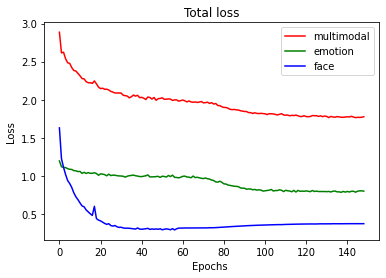

In [8]:
plt.title("Total loss")
plt.ylabel("Loss ")
plt.xlabel("Epochs ")
plt.plot(training_losses['multimodal_loss'].total_loss[skip_epoch_plot:], color='red', label='multimodal')
plt.plot(training_losses['emotion_loss'].total_loss[skip_epoch_plot:], color='green', label='emotion')
plt.plot(training_losses['face_loss'].total_loss[skip_epoch_plot:], color='blue', label='face')
plt.legend(loc="upper right")

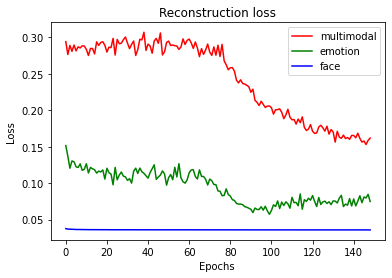

In [9]:
plt.title("Reconstruction loss")
plt.ylabel("Loss ")
plt.xlabel("Epochs ")

plt.plot(training_losses['multimodal_loss'].reconstruction_loss[skip_epoch_plot:], color='red', label='multimodal')
plt.plot(training_losses['emotion_loss'].reconstruction_loss[skip_epoch_plot:], color='green', label='emotion')
plt.plot(training_losses['face_loss'].reconstruction_loss[skip_epoch_plot:], color='blue', label='face')
plt.legend(loc="upper right")

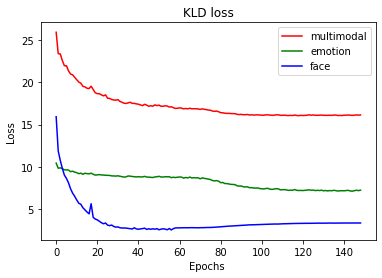

In [10]:
plt.title("KLD loss")
plt.ylabel("Loss ")
plt.xlabel("Epochs ")

plt.plot(training_losses['multimodal_loss'].kld_loss[skip_epoch_plot:], color='red', label='multimodal')
plt.plot(training_losses['emotion_loss'].kld_loss[skip_epoch_plot:], color='green', label='emotion')
plt.plot(training_losses['face_loss'].kld_loss[skip_epoch_plot:], color='blue', label='face')
plt.legend(loc="upper right")

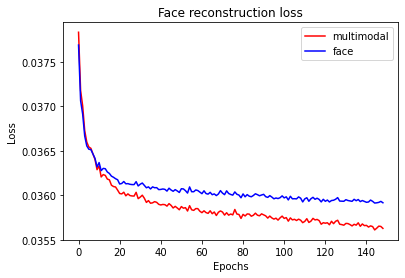

In [11]:
plt.title("Face reconstruction loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")

plt.plot(training_losses['multimodal_loss'].faces_reconstruction_loss[skip_epoch_plot:], color='red', label='multimodal')
#plt.plot(training_losses['emotion_loss'].faces_reconstruction_loss[skip_epoch_plot:], color='green', label='emotion')
plt.plot(training_losses['face_loss'].faces_reconstruction_loss[skip_epoch_plot:], color='blue', label='face')
plt.legend(loc="upper right")

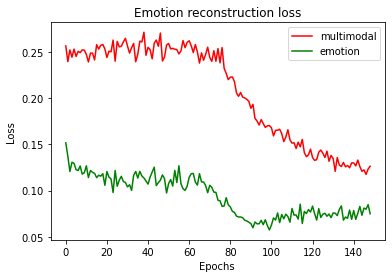

In [12]:
plt.title("Emotion reconstruction loss")
plt.ylabel("Loss ")
plt.xlabel("Epochs ")

plt.plot(training_losses['multimodal_loss'].emotions_reconstruction_loss[skip_epoch_plot:], color='red', label='multimodal')
plt.plot(training_losses['emotion_loss'].emotions_reconstruction_loss[skip_epoch_plot:], color='green', label='emotion')
#plt.plot(training_losses['face_loss'].emotions_reconstruction_loss[skip_epoch_plot:], color='blue', label='face')
plt.legend(loc="upper right")

In [13]:
def testBatch(model, dataset_loader, img_size=64, use_cuda=True):
    sample = next(iter(dataset_loader))
    images = sample['image']
    labels = sample['cat']
    
    if use_cuda:
        images = images.cuda()
        labels = labels.cuda()
        
    input_array = np.zeros(shape=(img_size, 1, 3), dtype="uint8")
    reconstructed_array = np.zeros(shape=(img_size, 1, 3), dtype="uint8")
    reconstructed_emotions = []
    
    plt.figure(figsize = (40,10))
    
    batch_size = images.shape[0]
    
    reconstructed_images, reconstructed_emotions, _, _ = model(faces=images, emotions=labels)

    for idx in range(4):
        input_image = images[idx]
        
        # storing the input image
        input_image_display = np.array(input_image.cpu()*255., dtype='uint8').transpose((1, 2, 0))
        input_array = np.concatenate((input_array, input_image_display), axis=1)
        
        # generating the reconstructed image and adding to array
        input_image = input_image.view(1, 3, img_size, img_size)
        
        reconstructed_img = reconstructed_images[idx].cpu().view(3, img_size, img_size).detach().numpy()
        reconstructed_img = np.array(reconstructed_img*255., dtype='uint8').transpose((1, 2, 0))
        reconstructed_array = np.concatenate((reconstructed_array, reconstructed_img), axis=1)
        
    # remove first, blank column, and concatenate
    input_array = input_array[:,1:,:]
    reconstructed_array = reconstructed_array[:,1:,:]
    display_array = np.concatenate((input_array, reconstructed_array), axis=0)
    plt.imshow(display_array)
    
    print([Rd.emocat[label.item()] for label in labels[:4]])
    print([Rd.emocat[emo.item()] for emo in torch.argmax(reconstructed_emotions, 1)[:4]])

['calm', 'surprised', 'surprised', 'calm']
['calm', 'sad', 'surprised', 'calm']


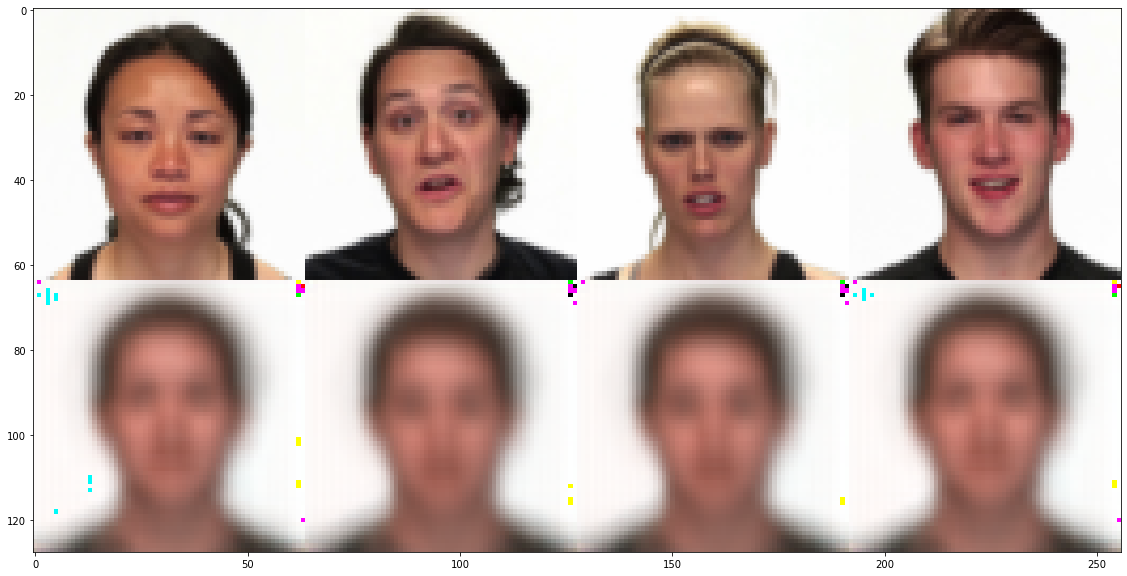

In [14]:
testBatch(model, testset_loader)

In [15]:
from tqdm import tqdm
def emotion_accuracy(model, dataset_loader):
    
    match = 0
    total = 0
    
    for sample in tqdm(iter(dataset_loader)):
        labels = sample['cat'].cuda()
                            
        _, reconstructed_emotions, _, _ = model(faces=None, emotions=labels)  
        emotion_cat = torch.argmax(reconstructed_emotions, 1)  
        
        for idx in range(len(labels)):
            total += 1
            if labels[idx] == emotion_cat[idx]:
                match += 1
    
    acc = match / total
    return acc

In [16]:
print(emotion_accuracy(model, testset_loader))

100%|████████████████████████████| 12/12 [00:06<00:00,  1.91it/s]

0.9638888888888889


In [17]:
save_model = False

if save_model:
    # Do a global and a local save of the model (local to Hydra outputs)
    torch.save(mvae_model.state_dict(), cfg.model_save_path)
    torch.save(mvae_model.state_dict(), "ravdess_mvae_pretrained.pt")
    logger.info(f"Saved model to '{cfg.train.plain.model_save_path}', and also locally.")

    # Do a global and local save of the training stats (local to Hydra outputs)
    torch.save(training_losses, cfg.stats_save_path)
    torch.save(training_losses, "ravdess_mvae_pretrained_stats.pt")
    logger.info(f"Saved model to '{cfg.train.plain.stats_save_path}', and also locally.")